In [1]:
# This filel uses  'gagne.txt', 'xu18.dat', 'zucker20.tsv'
# some final figures for moving_group paper in here


In [2]:

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib 
#import astropy.io.fits as pyfits  # astronomy fits format routines

#import scipy.ndimage as ndimage  #image routines 
from scipy.integrate import odeint  #integrator

from pandas import DataFrame, read_csv
import pandas as pd 
from scipy.optimize import curve_fit

matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14) 

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d



In [3]:
# some constants
class Galconstants:
    #R0=8.15   # Galactocentric radius of Sun units kpc
    #Vc0=236.0   # assumed for vphi tangential Local standard of rest units km/s 
    #these are from Reid+19
    
    #R0 = 8.34   #used by Gaia collab katz+18, from Reid+14
    #Vc0 = 240.0
    
    R0=8.122 #  Galactocentric radius of Sun units kpc, Gravity collaboration 2018
    Vc0=233.3   # assumed for vphi tangential Local standard of rest units km/s, using 
    # schoenrich+10's Vsun and the Gravity collaboration+18 value

    Usun = 11.1  # peculiar motion of Sun w.r.t LSR, Schonrich+10 , units km/s
    Vsun = 12.24
    Wsun = 7.25

    Zsun = 5.5   # we need a vertical offset for the Sun, Reid+19, in pc 
    
    theta_sun = np.pi  # this is angle location of Sun, units radians
    
    #alpha_h = 1834.1  # units (km/s)^2 kpc^{-3/2} or kpc^1/2 Gyr^-2
    # this describe vertical potential
    yr = 365.25*24.0*60.0*60.0 # year in seconds
    beta = -0.05  # this describes slope of rotation curve, approximately the value by McGaugh2019
    om0 = Vc0/R0   # angular rotation rate of LSR
    L0 = R0*Vc0  # Lodot
    #alpha1=0.0
    #alpha2=0.0
    alpha_3=0.0
    alpha_1 = 4207.01  # a z ,z2 poly fit
    alpha_2 = -2792.22
    alpha_h = 0.

Gcon = Galconstants;  # make the class!


print('om0={:.1f} km/s/kpc'.format(Gcon.om0))
# these units are equivalent to 1/Gyr

rot_period = 2.0*np.pi/Gcon.om0
print('rot_period = {:.0f} Myr'.format(rot_period*1e3))
print('kap_period = {:.0f} Myr'.format(rot_period*1e3/np.sqrt(2.)))


# http://www.astro.ucla.edu/~drodrigu/UVWCalc.html#data  uvw converter! possibly helpful!

om0=28.7 km/s/kpc
rot_period = 219 Myr
kap_period = 155 Myr


In [3]:
#print(40*np.pi/180 * 8.1)

5.654866776461628


### For orbit integration

The total gravitational potential
$$ \Phi(R,z) = \Phi_R(R) + \Phi_z(z)$$ 

Rotation curve slope set by parameter $\beta$.  Gravitational potential $\Phi_R(R)$.

If $\beta =0$:
$$ \Phi_R(R) = v_{c0}^2 \ln \left( \frac{R}{R_0} \right) $$
$$ \frac{d\Phi_R}{dR } =\frac{ v_{c0}^2  }{R} $$
$$ v_c(R) = \sqrt{R \frac{d\Phi_R}{dR }}  = v_{c0} $$
If $\beta \ne 0$:
$$ \Phi_R(R) = \frac{v_{c0}^2}{2 \beta}  \left( \frac{R}{R_0}\right)^{2 \beta} $$ 
$$ \frac{d\Phi_R}{dR } = \frac{v_{c0}^2}{R_{c0}} \left( \frac{R}{R_0} \right)^{2\beta -1}  $$
$$ v_c(R)= \sqrt{R \frac{d\Phi_R}{dR }}   = v_{c0} \left(  \frac{R}{R_0}\right)^\beta $$
where $R_0$ is Galactocentric radius of the Sun and $v_{c0}$ is the local standard of rest or the 
tangential velocity of a circular orbit with radius $R_0$.

Vertically $\Phi_z(z)$
$$\frac{d\Phi_z}{dz} = \alpha_h \sqrt{|z|} {\rm sign}(z)$$ is a good fit to $K_z$ where $K_z$ is in Figure 8 for $-1 \times$ the vertical acceleration by Holmberg & Flynn 2000.  The fit gives constant  
$$\alpha_h = 0.058 ({\rm km/s})^2 \ {\rm pc}^{-3/2}
= 0.058 \frac{({\rm km/s})^2 }{ {\rm pc}^{3/2}} \times \left(\frac{1e3\ {\rm pc}}{\rm kpc}\right)^{3/2} = 1834 ({\rm km/s})^2 \ {\rm kpc}^{-3/2} $$

Integrate the derivative
$$ \Phi_z(z) = \frac{2}{3} \alpha_h |z|^\frac{3}{2} + {\rm constant} $$


I could also use 
$$\frac{d\Phi_z}{dz} = \alpha_h \sqrt{|z|} {\rm sign}(z) + \alpha_1 z + \alpha_2 z^2{\rm sign}(z)  + \alpha^3 z^3$$ 
giving 
$$ \Phi_z(z) = \frac{2}{3} \alpha_h |z|^\frac{3}{2} + {\rm constant} 
+ \frac{1}{2} \alpha_1 z^2 + \frac{1}{3}\alpha_2 |z|^3 + \frac{1}{4}\alpha_3 z^4 $$


### equations of motion in Hamiltonian form
$$ H(\theta,R,z;L,p_R,p_z) = \frac{L^2}{2R^2} + \frac{p_R^2}{2} + \frac{p_z^2}{2}  + \Phi_R(R) + \Phi_z(z)$$
Hamilton's equations give
\begin{align*}
 \dot \theta &= \frac{\partial H}{\partial L} = \frac{L}{R^2} \\
 \dot R &= \frac{\partial H}{\partial p_R}  = p_R \\
 \dot z & = \frac{\partial H}{\partial p_z}  = p_z
 \end{align*}
 \begin{align*}
 \dot L & = -\frac{\partial H}{\partial \theta} = 0 \\ 
 \dot p_R &= -\frac{\partial H}{\partial R}  = \frac{L^2}{R^3} - \frac{\partial \Phi_R}{\partial R} \\
 \dot p_z &= -\frac{\partial H}{\partial z}  =  - \frac{\partial \Phi_z}{\partial z} \\
 \end{align*}

### slope parameter
$$ \beta = \left. \frac{dv_c(R_g)}{dR_g}\right|_{R_\odot} \frac{R_\odot}{V_{LSR}} $$

In [4]:
# for orbit integration we work in units of km/s, kpc and Gyr, 
# these are functions needed for orbit integration

# vc0 is circular velocity at r0
# beta sets power law for rotation curve v = vc0 * (r/r0)**beta
# phi(R) is gravitational potential
# return the radial derivative of the gravitational potential 
def dphidr(r,beta,vc0,r0):
    fac = vc0**2/r
    if (beta==0):  # a flat rotation curve
        return fac
    else:
        return fac*(r/r0)**(2*beta)  

# gravitational potential as a function of radius
# here vc0 is circular velocity at r0
# beta gives slope of rotation curve
# return gravitational potential, radial part
def phi_R(r,beta,vc0,r0):
    if (beta==0):
        return vc0**2*np.log(r/r0)
    else:
        fac = 2*beta
        return (vc0**2/fac)*(r/r0)**fac
    
# return vertical acceleration using sqrt fit to holmberg and Flynn 2000 Kz curve in their Figure 8
def dphidz(z,alpha_h,alpha_1,alpha_2,alpha_3):
    xh = alpha_h*np.sqrt(np.abs(z))*np.sign(z)
    y = alpha_1*z + alpha_2* z**2 * np.sign(z) + alpha_3*z**3
    return xh + y

# function used for integratration of orbits
# H(theta,r,z;L,pr, pz) = pr^2/2 + L^2/(2r^2) + Phi_R(r) + p_z^2/2 + Phi_Z(z)
#    y = [theta,r,z,L,dotr,dotz]    statevector used as variable in integrator
# t is time
# this is a useful function for passing to integrator odeint
# this now integrates in 3D
def func(y,t,beta,vc0,r0,alpha_h,alpha_1,alpha_2,alpha_3):
    theta = y[0]
    r  =  y[1]
    z  =  y[2]
    L  =  y[3]
    pr =  y[4]  
    pz =  y[5]
    dthetadt=L/r**2
    drdt = pr
    dzdt = pz
    dprdt = L**2/r**3 - dphidr(r,beta,vc0,r0)
    dLdt = 0.0
    dpzdt = -dphidz(z,alpha_h,alpha_1,alpha_2,alpha_3)
    dydt = np.zeros(6)  # allocate a vector
    dydt[0] = dthetadt
    dydt[1] = drdt
    dydt[2] = dzdt
    dydt[3] = dLdt
    dydt[4] = dprdt 
    dydt[5] = dpzdt
    return dydt
      
# return an angle between [-pi,pi]
def residual(theta):
    x = theta
    while (x<-np.pi):
        x += 2*np.pi
    while (x>np.pi):
        x -= 2*np.pi
    return x

# same as residual except for arrays
def residual_arr(theta):
    ii = (theta<-np.pi)
    theta[ii] += 2*np.pi
    ii = (theta>np.pi)
    theta[ii] -= 2*np.pi
    return theta

### A logarithmic spiral with a pattern speed
In polar coordinates a log spiral we describe with peak at  $R(\theta,t)$ where 
$$ \alpha_s \ln \left( \frac{R(\theta,t)}{R_{s0}} \right)  = \theta - \theta_\odot - \Omega_s t $$
The arm has a peak at $R_{s0}$ at $\theta_\odot$ at $t=0$.
The arm pitch angle is $p  = {\rm arctan}\ \alpha_s^{-1}$.  The pattern speed is $\Omega_s$.

For us rotation has $\dot \theta <0$ so a trailing arm has winding angle $\alpha_s>0$ but the pattern should be 
moving with the rotation so the pattern speed of the spiral pattern $\Omega_s <0$.

In [6]:
# routines related to spiral arm locations


# returns radius of a spiral at time t and at angle dtheta 
# here dtheta = theta - theta_sun where theta_sun is angular location of Sun
# here Rs0 is radius R value of spiral peak at dtheta=0
# Omega_s is spiral pattern speed
# alpha sets winding angle 
# this is a logarithmic spiral
def r_spiral(dtheta,alpha_s,Rs0,Omega_s,t):
    x = (dtheta - Omega_s*t)/alpha_s
    return Rs0*np.exp(x)

# return Rs0 if given radius Rs(dtheta,t) of a spiral at time t and dtheta
# Rs0 is radius at angle theta0 and time t=0
# Omega_s is pattern speed, alpha_s is winding parameter
def rs0_spiral(dtheta,alpha_s,Rs,Omega_s,t):
    #x = (residual(dtheta) - Omega_s*t)
    x = (dtheta - Omega_s*t)
    #if (x < 0):
    #    x += 2.0*np.pi
    y = x/alpha_s
    return Rs*np.exp(-y)

# print winding or pitch angle in degrees using winding parameter alpha_s
def winding_angle(alpha_s):
    wa = np.pi/2 - np.arctan(np.abs(alpha_s))  # equivalent to arctan 1/alpha
    wa_deg = wa*180/np.pi  # convert to degrees
    print(wa,wa_deg, "deg")

# for us: alpha>0 and Omega_s <0 for Galactic rotation dot\theta = Omega<0


# return radius, x, y, of spiral at time t1 for given theta values in th_arr (could be an array)
# here Rs0 is radius of spiral at theta=theta_sol  and t=0
# Omega_s is spiral pattern speed, alpha_s = winding parameter
# theta_sun is location of sun
def spiral_rxy(th_arr,alpha_s,Rs0,Omega_s,theta_sun,t1):
    rs = r_spiral(th_arr,alpha_s,Rs0,Omega_s,t1)
    xs = rs*np.cos(th_arr-theta_sun)
    ys = rs*np.sin(th_arr-theta_sun)
    return rs,xs,ys


In [5]:
# for storing integration outputs
class integration_output:
    t_arr = []  # time 
    dtheta_arr = []   # theta from theta_sun rad
    r_arr = []  # galatocentric radius kpc
    x_arr = []  # galactocentric x,y,z kpc
    y_arr = []
    z_arr = []
    u_arr =[]    # -vr  km/s
    v_arr = []   # vphi
    w_arr = []   # vz 
    aw_arr = []  # an age weight
    
# npts_integrated=301   #number of points to store integration

# This routine integrates the orbit backward in a rotation curve with slope beta
# dtheta_init, r_init, z_init are initial coords of neighborhood (radians, kpc, kpc)
# u_init, vphi_init, w_init are initial velocities (km/s)
# Gcon is a class that contains Galactic constants
#   beta,vc0,r0,alpha_h used in integration routines (rotation curve slope, LSR velocity, radius of sun, vertical parm)
#   theta_sun is angle of sun
# tmax is how far back to integrate, tmax should be negative and is in Gyr
# returns orbit in a bunch of arrays, integrates
def back_integrate_orbit(dtheta_init,r_init,z_init,vr_init,vphi_init,vz_init,Gcon,tmax,npts_integrated):
    #tmax = -0.1 # in Gyr, how far back to go!
    t_arr = np.linspace(0, tmax, npts_integrated)  # load a time vector, 
    L_init = -r_init*vphi_init    # note the minus sign  !!!!!!!!!!! dot theta <0 assumed
    y0=[dtheta_init,r_init,z_init,L_init,vr_init,vz_init]  # initial state vector 
    sol = odeint(func, y0, t_arr, args=(Gcon.beta,Gcon.Vc0,Gcon.R0,Gcon.alpha_h,\
                                        Gcon.alpha_1,Gcon.alpha_2,Gcon.alpha_3)) # do the integration
    i_output = integration_output()
    i_output.dtheta_arr = sol[:,0]  # unpack the results of the integration
    i_output.r_arr      = sol[:,1]
    i_output.z_arr      = sol[:,2]
    L_arr      = sol[:,3]
    vr_arr     = sol[:,4]
    vz_arr     = sol[:,5]
    i_output.v_arr   = L_arr/i_output.r_arr
    i_output.u_arr = -1.0*vr_arr
    i_output.w_arr = vz_arr
    i_output.t_arr = t_arr
    i_output.x_arr = i_output.r_arr*np.cos(Gcon.theta_sun + i_output.dtheta_arr)  
    i_output.y_arr = i_output.r_arr*np.sin(Gcon.theta_sun + i_output.dtheta_arr)
    return i_output  # return orbit as a bunch of arrays


In [6]:
# Integrate a randomly selected initial orbit that is consistent with the xyz,uvw errors in the table
# df is table of stellar associations from Gagne+18a (mostly)
# i tells you which association
# Gcon is a class that contains galactic constants
# efac is how much of std to multiply by for random variations to initial conditions
def back_integrate_sa(df,i,Gcon,efac,npts_integrated):
    # set up initial conditions
    r_init      = Gcon.R0-df['X'][i]/1e3  # initial radius, note X in pc -> kpc
    dtheta_init = -df['Y'][i]/1e3/Gcon.R0 # initial angle
    z_init      =  (df['Z'][i] + Gcon.Zsun)/1e3; # pc to kpc  initial z
    vr_init     = -(df['U'][i] + Gcon.Usun);   # initial radial velocity 
    vphi_init   =  (df['V'][i] + Gcon.Vsun + Gcon.Vc0) # initial tangential velocity 
    #(sign for vphi is reversed later in integration)
    vz_init     =   df['W'][i] + Gcon.Wsun   # initial vertical velocity
    # add in random errors
    r_init      += efac*np.random.normal()*df['e_x'][i]/1e3   # pc to kpc
    dtheta_init += efac*np.random.normal()*df['e_y'][i]/1e3/Gcon.R0   # pc to radians
    z_init      += efac*np.random.normal()*df['e_z'][i]/1e3   #pc to kpc
    vr_init     += efac*np.random.normal()*df['e_u'][i]   # km/s
    vphi_init   += efac*np.random.normal()*df['e_v'][i] 
    vz_init     += efac*np.random.normal()*df['e_w'][i] 
    tmax = -1.0*(df['age'][i] + 2*df['e_age'][i])/1e3  # set max backwards integration time in Gyr
    # do the backwards integration
    i_output = \
        back_integrate_orbit(dtheta_init,r_init,z_init,vr_init,vphi_init,vz_init,Gcon,tmax,npts_integrated)
    tago = -1*i_output.t_arr*1e3  # time ago in Myr
    # create an array that gives a gaussian weighting based on estimated cluster age in Myr
    age_weight = np.exp( -0.5*(tago - df['age'][i])**2 /(df['e_age'][i])**2)
    i_output.aw_arr = age_weight # an array that is 1 if is a likely age
    return i_output


# same as previous routine except integrate to tmax<0 in Gyr
# efac is a factor to multiply the error in orbital initial conditions
def back_integrate_sa_tmax(df,i,Gcon,efac,npts_integrated,tmax):
    # set up initial conditions
    r_init      = Gcon.R0-df['X'][i]/1e3  # initial radius, note X in pc -> kpc
    dtheta_init = -df['Y'][i]/1e3/Gcon.R0 # initial angle
    z_init      =  (df['Z'][i] + Gcon.Zsun)/1e3; # pc to kpc  initial z
    vr_init     = -(df['U'][i] + Gcon.Usun);   # initial radial velocity 
    vphi_init   =  (df['V'][i] + Gcon.Vsun + Gcon.Vc0) # initial tangential velocity 
    #(sign for vphi is reversed later in integration)
    vz_init     =   df['W'][i] + Gcon.Wsun   # initial vertical velocity
    # add in random errors
    r_init      += efac*np.random.normal()*df['e_x'][i]/1e3   # pc to kpc
    dtheta_init += efac*np.random.normal()*df['e_y'][i]/1e3/Gcon.R0   # pc to radians
    z_init      += efac*np.random.normal()*df['e_z'][i]/1e3   #pc to kpc
    vr_init     += efac*np.random.normal()*df['e_u'][i]   # km/s
    vphi_init   += efac*np.random.normal()*df['e_v'][i] 
    vz_init     += efac*np.random.normal()*df['e_w'][i] 
    #tmax = -1.0*(df['age'][i] + 2*df['e_age'][i])/1e3  # set max backwards integration time in Gyr
    # do the backwards integration
    i_output = \
        back_integrate_orbit(dtheta_init,r_init,z_init,vr_init,vphi_init,vz_init,Gcon,tmax,npts_integrated)
    tago = -1*i_output.t_arr*1e3  # time ago in Myr
    # create an array that gives a gaussian weighting based on estimated cluster age in Myr
    age_weight = np.exp( -0.5*(tago - df['age'][i])**2 /(df['e_age'][i])**2)
    i_output.aw_arr = age_weight # an array that is 1 if is a likely age
    return i_output


    

In [7]:
# read in a data table that has Gagne 2018 Apj,856's table 1+9 in it of stellar associations
df = pd.read_csv('gagne.txt', comment='#')
cols = df.columns
# convert everything but first column to floats
for col in cols[1:]:
    df[col] = df[col].astype(float)
    
# note: units for this table are pc and km/s and Myr

In [10]:
#df # if you want to look at the table

,name,X,Y,Z,U,V,W,e_x,e_y,e_z,e_u,e_v,e_w,age,e_age,junk
0,ROPH,124.79,-15.23,37.60,-5.90,-13.50,-7.90,1.33,0.51,0.66,1.30,4.70,4.30,1.0,1.0,NaN
1,TAU,-116.30,6.70,-35.90,-14.30,-9.30,-8.80,11.40,10.80,10.10,3.10,4.50,3.40,1.5,1.0,NaN
2,EPSC,49.90,-84.80,-25.60,-9.90,-19.30,-9.70,2.50,3.60,4.00,1.60,2.20,2.00,4.0,1.0,NaN
3,CRA,132.45,-0.21,-42.43,-3.70,-15.70,-8.80,3.71,0.75,2.04,1.30,2.20,2.20,4.5,0.5,NaN
4,TWA,14.40,-47.70,22.70,-11.60,-17.90,-5.60,12.20,9.70,3.90,1.80,1.80,1.60,10.0,3.0,NaN
5,USCO,121.20,-17.00,48.90,-4.90,-14.20,-6.50,17.00,8.20,8.90,3.70,3.20,2.30,10.0,3.0,NaN
6,UCRA,142.10,-1.20,-39.20,-3.70,-17.10,-8.00,7.30,2.40,5.90,3.00,1.80,1.20,10.0,3.0,NaN
7,ETAC,33.65,-81.36,-34.81,-10.00,-22.30,-11.70,0.65,0.98,0.71,1.60,2.80,1.80,11.0,3.0,NaN
8,LCC,54.30,-94.20,5.80,-7.80,-21.50,-6.20,11.90,12.40,13.70,2.70,3.80,1.80,15.0,3.0,NaN
9,UCL,107.50,-60.90,26.50,-4.70,-19.70,-5.20,21.00,19.60,13.50,3.80,3.00,1.70,16.0,2.0,NaN


In [9]:
# read in molecular cloud locations from zucker+20
df_zu20 = pd.read_csv('zucker20.tsv', comment='#',sep=';')
cols = df_zu20.columns
# convert everything but first 3 columns to floats
for col in cols[3:]:
    df_zu20[col] = df_zu20[col].astype(float)
    
# Distances are original in pc, we convert to kpc

df_zu20['lrad'] = df_zu20['GLON']*np.pi/180.0   # galactic longitude in radians
df_zu20['brad'] = df_zu20['GLAT']*np.pi/180.0   # galactic latitude in radians
df_zu20['x_g']  = df_zu20['d50']*np.cos(df_zu20['lrad'])*np.cos(df_zu20['brad'])/1e3 - Gcon.R0 
df_zu20['y_g']  = df_zu20['d50']*np.sin(df_zu20['lrad'])*np.cos(df_zu20['brad'])/1e3
df_zu20['z_g']  = df_zu20['d50']*np.sin(df_zu20['brad'])/1e3  #in kpc
df_zu20['R_g']  = np.sqrt(df_zu20['x_g']**2 + df_zu20['y_g']**2)  # galactic radius in kpc
df_zu20['theta_g']  = residual_arr(np.arctan2(df_zu20['y_g'], df_zu20['x_g']))   # galactic angle in radians
df_zu20['x_g_near']  = df_zu20['d16']*np.cos(df_zu20['lrad'])*np.cos(df_zu20['brad'])/1e3 - Gcon.R0 
df_zu20['y_g_near']  = df_zu20['d16']*np.sin(df_zu20['lrad'])*np.cos(df_zu20['brad'])/1e3
df_zu20['z_g_near']  = df_zu20['d16']*np.sin(df_zu20['brad'])/1e3  #in kpc
df_zu20['R_g_near']  = np.sqrt(df_zu20['x_g_near']**2 + df_zu20['y_g_near']**2)  
df_zu20['theta_g_near']  = residual_arr(np.arctan2(df_zu20['y_g_near'], df_zu20['x_g_near'])) 
df_zu20['x_g_far']  = df_zu20['d84']*np.cos(df_zu20['lrad'])*np.cos(df_zu20['brad'])/1e3 - Gcon.R0 
df_zu20['y_g_far']  = df_zu20['d84']*np.sin(df_zu20['lrad'])*np.cos(df_zu20['brad'])/1e3
df_zu20['z_g_far']  = df_zu20['d84']*np.sin(df_zu20['brad'])/1e3  #in kpc
df_zu20['R_g_far']  = np.sqrt(df_zu20['x_g_far']**2 + df_zu20['y_g_far']**2)  
df_zu20['theta_g_far']  = residual_arr(np.arctan2(df_zu20['y_g_far'], df_zu20['x_g_far'])) 

In [19]:
#df_zu20

,RAJ2000,DEJ2000,Name,GLON,GLAT,d16,d50,d84,lrad,brad,...,x_g_near,y_g_near,z_g_near,R_g_near,theta_g_near,x_g_far,y_g_far,z_g_far,R_g_far,theta_g_far
0,269.5462,-5.5500,Aquila_Rift,21.8,9.2,266.0,278.0,289.0,0.380482,0.160570,...,-7.878200,0.097513,0.042528,7.878803,3.129216,-7.857119,0.105945,0.046206,7.857834,3.128110
1,265.3954,-8.9942,Aquila_Rift,16.7,11.1,204.0,208.0,215.0,0.291470,0.193732,...,-7.930260,0.057525,0.039274,7.930468,3.134339,-7.919921,0.060627,0.041392,7.920153,3.133938
2,264.7861,-6.8385,Aquila_Rift,18.3,12.7,249.0,254.0,258.0,0.319395,0.221657,...,-7.891377,0.076271,0.054742,7.891745,3.131928,-7.883041,0.079028,0.056720,7.883437,3.131568
3,267.0286,-4.5071,Aquila_Rift,21.5,11.9,277.0,280.0,283.0,0.375246,0.207694,...,-7.869813,0.099339,0.057119,7.870440,3.128971,-7.864351,0.101491,0.058356,7.865005,3.128688
4,260.2646,-6.7838,Aquila_Rift,16.0,16.6,158.0,163.0,166.0,0.279253,0.289725,...,-7.976451,0.041736,0.045139,7.976560,3.136360,-7.969081,0.043849,0.047424,7.969202,3.136090
5,302.5332,-3.5411,Aquila_S,38.9,-19.1,120.0,123.0,126.0,0.678933,-0.333358,...,-8.033752,0.071207,-0.039266,8.034068,3.132729,-8.029340,0.074768,-0.041229,8.029688,3.132281
6,300.6697,-2.1373,Aquila_S,39.3,-16.8,125.0,128.0,131.0,0.685914,-0.293215,...,-8.029398,0.075793,-0.036129,8.029756,3.132153,-8.024954,0.079432,-0.037863,8.025347,3.131695
7,300.6283,-3.7318,Aquila_S,37.8,-17.5,134.0,135.0,137.0,0.659734,-0.305433,...,-8.021020,0.078328,-0.040295,8.021402,3.131828,-8.018759,0.080082,-0.041197,8.019159,3.131606
8,298.0500,-3.4869,Aquila_S,36.8,-15.1,140.0,143.0,146.0,0.642281,-0.263545,...,-8.013768,0.080968,-0.036471,8.014177,3.131489,-8.009130,0.084438,-0.038034,8.009575,3.131050
9,250.8110,-49.0520,Ara,336.7,-2.0,1049.0,1064.0,1076.0,5.876524,-0.034907,...,-7.159137,-0.414674,-0.036610,7.171136,-3.083735,-7.134354,-0.425348,-0.037552,7.147022,-3.082043


In [10]:
#colors for plots, must have the correct length!
mcolorlist = ('indigo','darkviolet','violet','blue','cornflowerblue','deepskyblue','aqua',\
              'forestgreen','lawngreen','yellowgreen','gold','darkolivegreen','orange','peru','tomato','red',\
              'firebrick','darkslategrey','cornflowerblue','plum')

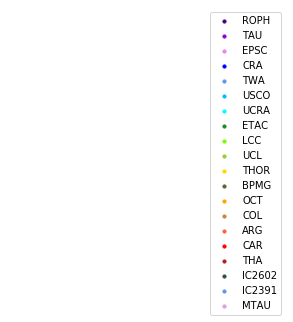

In [11]:
# show the colors we are using for each association
fig,axarr = plt.subplots(1,1,figsize=(5,5))
for i in range(len(mcolorlist)):
    #lt.figure()
    axarr.scatter(0,-10,s=10,color=mcolorlist[i],label=df['name'][i])
    plt.axis('off')
    axarr.set_xlim([0,20])
    axarr.set_ylim([0,20])
    axarr.legend()
    plt.savefig('mycolors.png')

In [12]:
# make r theta plots but only include points within [age_min,age_max) 
# and limits z between (zmin,zmax)
# here df is the stellar association table,
# npoints is the number of integrations per stellar association
# Gcon is the structure containing galactic constants
# calls back-integrate_sa()
# note that npts_integrated is a global variable telling us how many points are in each integration output
npts_integrated=301   #number of points to store integration
def oneplot(age_min,age_max,npoints,df,Gcon,zmin,zmax,figname):
    fig,axarr = plt.subplots(1,1,sharex=False,sharey=False,figsize=(11,4.5))
    plt.subplots_adjust(left=0.11, bottom=0.17, right=0.99, top=0.86, wspace=None, hspace=None)
    rgba_colors = np.zeros((npts_integrated,4))  # color list including alpha
    
    todeg = 180.0/np.pi   # convert angles to degrees
    # loop over associations, for labels only, order of age
    for isa in range(len(df.X)):
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        axarr.scatter(0,0,color=rgba,s=5,label=df['name'][isa])  # for labelling
    # loop over associations
    for isa in range(len(df.X)-1,-1,-1): # go from oldest association to youngest association
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        for j in range(npoints):   # number of integrations to do for each stellar association
            rgba_colors[:,0]=rgba[0]
            rgba_colors[:,1]=rgba[1]
            rgba_colors[:,2]=rgba[2]
            i_output = back_integrate_sa(df,isa,Gcon,1,npts_integrated)  # integration output information
            rgba_colors[:,3]=i_output.aw_arr  # weights based on age
            iia = (np.abs(i_output.t_arr) >= age_min/1e3) & (np.abs(i_output.t_arr) < age_max/1e3)
            iib = (i_output.z_arr > zmin) & (i_output.z_arr < zmax)
            ii = iia & iib  # only plot age range and z range
            #print(ii)
            #if (j==0):
                #axarr.scatter(0,0,color=rgba,s=5,label=df['name'][isa])  # for labelling

            axarr.scatter(i_output.dtheta_arr[ii]*todeg,i_output.r_arr[ii],color=rgba_colors[ii],s=2,zorder=2)
            
    axarr.set_xlabel(r'$\theta_g -\theta_\odot$ (deg)',fontsize=18);  
    axarr.set_ylabel(r'Radius $R_g$ (kpc)',fontsize=18);
    axarr.set_xlim([115,-6])
    #axarr.set_xlim([135,-6])
    axarr.set_ylim([7.1,8.8])
    xmin, xmax = axarr.get_xlim() # this is angle in degrees
    ymin, ymax = axarr.get_ylim()
    axarr.plot([xmin,xmax],[Gcon.R0,Gcon.R0],':',color='grey',zorder=1)  # grey dotted lines for Sun position
    axarr.plot([0,0],[ymin,ymax],':',color='grey',zorder=1)
            
    axarr.legend(ncol=5,markerscale=4.,borderpad=0.2,labelspacing=0.1,\
                         handlelength=0.5,handletextpad=0.4,columnspacing=0.3,fontsize=14,loc='lower right')
    # rotation arrow
    axarr.arrow(21,8.56,-12,0,head_width=0.1,head_length=1.5,width=0.02)
    axarr.text(15,8.62,'rotation',fontsize=14,ha='center',va='center')
    
    # top vertical axis
    ax2 = axarr.twiny()  # share y axis
    t1 = xmin/todeg / Gcon.om0 *1e3  # should be time in Myr
    t2 = xmax/todeg / Gcon.om0 *1e3  
    ax2.set_xlim(t1,t2)
    ax2.set_xlabel(r'dynamic age estimate $(\theta_g - \theta_\odot)/\Omega_\odot$ (Myr)',fontsize=16,labelpad=10);
               
    if (len(figname)>3):
        plt.savefig(figname,dpi=300)
        


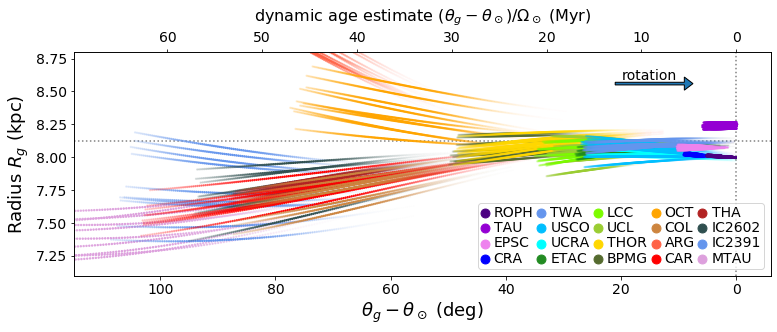

In [13]:
age_min = 0; age_max = 3000;   # age range in Myr
npoints=10
zmin=-10; zmax=10  # limits in kpc
figname='rtheta_all.png'
oneplot(age_min,age_max,npoints,df,Gcon,zmin,zmax,figname)


In [14]:
# make r theta plots but only include points within [age_min,age_max) and panels with different zranges
# here df is the stellar association table,
# npoints is the number of integrations per stellar association
# Gcon is the structure containing galactic constants
# zmin_arr is an array giving lower z values for each panel, dz is from the difference between them
# calls back-integrate_sa()
def z4plot(age_min,age_max,npoints,df,Gcon,zmin_arr,leg,figname):
    nz =  len(zmin_arr)  # number of z panels
    dz = zmin_arr[1]-zmin_arr[0]  # spacing in z
    fig,axarr = plt.subplots(nz,1,sharex=True,sharey=True,figsize=(9,11))
    plt.subplots_adjust(left=0.12, bottom=0.11, right=0.85, top=0.91, wspace=0, hspace=0)
    rgba_colors = np.zeros((npts_integrated,4))  # color list including alpha
    axarr[0].set_xlim([115,-3])
    axarr[0].set_ylim([7.1,8.8])
    todeg = 180.0/np.pi   # convert angles to degrees
    # loop over associations, for labels only, order of age
    for isa in range(len(df.X)):
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        axarr[0].scatter(0,0,color=rgba,s=2,label=df['name'][isa])  # for labelling
    # loop over associations
    for isa in range(len(df.X)-1,-1,-1): # go from oldest to youngest
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        for j in range(npoints):   # number of integrations per association
            rgba_colors[:,0]=rgba[0]
            rgba_colors[:,1]=rgba[1]
            rgba_colors[:,2]=rgba[2]
            i_output = back_integrate_sa(df,isa,Gcon,1,npts_integrated)  # do integration
            rgba_colors[:,3]=i_output.aw_arr  # age weights
            # only plot within age range
            iia = (np.abs(i_output.t_arr) >= age_min/1e3) & (np.abs(i_output.t_arr) < age_max/1e3)
            for k in range(nz):
                zb = zmin_arr[nz-k-1]
                iib = (i_output.z_arr > zb) & (i_output.z_arr < zb+dz)   # only plot within zrange
                ii = iia & iib
                #if (j==0) and (k==0):
                    #axarr[k].scatter(0,0,color=rgba,s=2,label=df['name'][isa])  # for labelling
                # plot points
                axarr[k].scatter(i_output.dtheta_arr[ii]*todeg,i_output.r_arr[ii],\
                                 color=rgba_colors[ii],s=3,zorder=2)
            
    axarr[nz-1].set_xlabel(r'$\theta_g -\theta_\odot$ (deg)',fontsize=18); 
    xmin, xmax = axarr[0].get_xlim()
    ymin, ymax = axarr[0].get_ylim()
    for k in range(nz):
        axarr[k].set_ylabel(r'$R_g$ (kpc)',fontsize=18);
        # grey dots for position of Sun
        axarr[k].plot([xmin,xmax],[Gcon.R0,Gcon.R0],':',color='grey',zorder=1)
        axarr[k].plot([0,0],[ymin,ymax],':',color='grey',zorder=1)
        # label zrange on top left
        zb = zmin_arr[nz-k-1]
        ostring = r'$z_g$={:.0f} to {:.0f} pc'.format(zb*1e3,(zb+dz)*1e3)
        axarr[k].text(112,8.5,ostring,fontsize=14)
            
    #axarr[0].legend(ncol=4,markerscale=3.,borderpad=0.1,labelspacing=0.1,\
    #                     handlelength=0.5,handletextpad=0.5,columnspacing=0.5,fontsize=14,loc='lower right')
    #axarr.arrow(17,8.50,-12,0,head_width=0.1,head_length=1.5,width=0.02)
    #axarr.text(11,8.57,'rotation',fontsize=14,ha='center',va='center')
    if (leg ==1):
        axarr[0].legend(ncol=1,markerscale=6.,borderpad=0.2,labelspacing=0.1,\
                handlelength=0.5,handletextpad=0.5,columnspacing=0.5,fontsize=14,\
                loc="upper right",bbox_to_anchor=(1.19,1))
    
    # top axis
    ax2 = axarr[0].twiny()  # share y axis
    t1 = xmin/todeg / Gcon.om0 *1e3  # should be time in Myr
    t2 = xmax/todeg / Gcon.om0 *1e3  
    ax2.set_xlim(t1,t2)
    ax2.set_xlabel(r'$t =(\theta_g - \theta_\odot)/\Omega_\odot$ (Myr)',fontsize=16,labelpad=10);
            
    if (len(figname)>3):
        plt.savefig(figname,dpi=300)
        


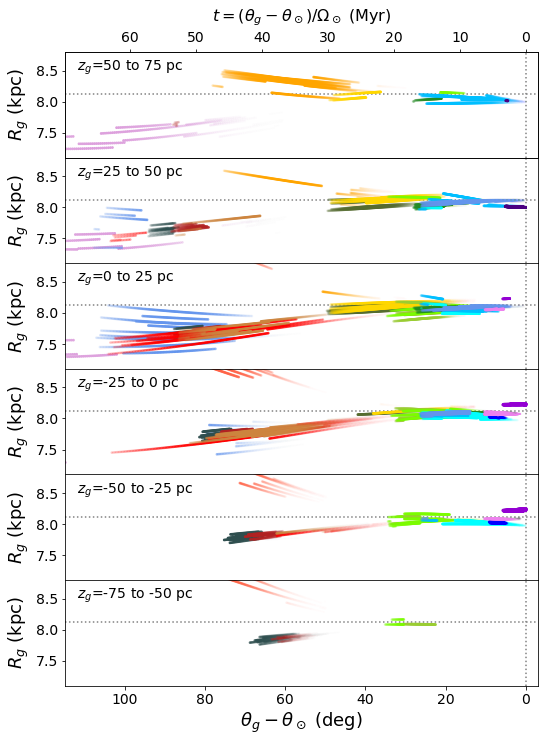

In [15]:
age_min = 0; age_max = 3000;   # age range in Myr
npoints=10
#zmin_arr=np.arange(-0.050,0.075,0.025)  # last number is dz, units kpc
zmin_arr=np.arange(-0.075,0.075,0.025)  # last number is dz, units kpc
figname='rtheta_all_z4.png'
leg=0
z4plot(age_min,age_max,npoints,df,Gcon,zmin_arr,leg,figname)


In [23]:
# reading positions of dust features from an image
# measuring split from an image using imageJ by Lallemont+19 fig14 
# and Vul extention
# this is needed for gray bars!
pixscale = (604.3-50.7)/3.0  # pix per kpc
print(pixscale)

# origin
x0,y0=634.333,604.333  # origin

# local split positions
xl_arr = []; yl_arr=[]
x,y=677.000,589.333 
xlal = (x-x0)/pixscale - Gcon.R0; ylal = -(y-y0)/pixscale; #print(xlal,ylal); 
xl_arr = np.append(xl_arr,xlal); yl_arr = np.append(yl_arr,ylal)
x,y=757.000,502.667
xlal = (x-x0)/pixscale - Gcon.R0; ylal = -(y-y0)/pixscale; #print(xlal,ylal)
xl_arr = np.append(xl_arr,xlal); yl_arr = np.append(yl_arr,ylal)
x,y=875.667,390.667
xlal = (x-x0)/pixscale- Gcon.R0; ylal = -(y-y0)/pixscale; #print(xlal,ylal)
xl_arr = np.append(xl_arr,xlal); yl_arr = np.append(yl_arr,ylal)


#vul points
xv_arr = []; yv_arr=[]
x,y=668,604
xlal = (x-x0)/pixscale- Gcon.R0; ylal = -(y-y0)/pixscale; #print(xlal,ylal)
xv_arr = np.append(xv_arr,xlal); yv_arr = np.append(yv_arr,ylal)
x,y=704,478
xlal = (x-x0)/pixscale- Gcon.R0; ylal = -(y-y0)/pixscale; #print(xlal,ylal)
xv_arr = np.append(xv_arr,xlal); yv_arr = np.append(yv_arr,ylal)
#print(xl_arr)
#print(yl_arr)
# measuring split from an image using imageJ by Lallemont+19 fig14 

# local spur numbers
xls_arr = []; yls_arr=[]
# add a pt that is orion
xlal = 0.4*np.cos(200.*np.pi/180)- Gcon.R0; ylal = 0.4*np.sin(200.*np.pi/180); print(xlal,ylal)
xls_arr = np.append(xls_arr,xlal); yls_arr = np.append(yls_arr,ylal)
x,y=596,586  
xlal = (x-x0)/pixscale- Gcon.R0; ylal = -(y-y0)/pixscale; print(xlal,ylal)
xls_arr = np.append(xls_arr,xlal); yls_arr = np.append(yls_arr,ylal)
x,y=640,480
xlal = (x-x0)/pixscale- Gcon.R0; ylal = -(y-y0)/pixscale; print(xlal,ylal)
xls_arr = np.append(xls_arr,xlal); yls_arr = np.append(yls_arr,ylal)
x,y=674,390
xlal = (x-x0)/pixscale- Gcon.R0; ylal = -(y-y0)/pixscale; print(xlal,ylal)
xls_arr = np.append(xls_arr,xlal); yls_arr = np.append(yls_arr,ylal)
x,y=690,314
xlal = (x-x0)/pixscale- Gcon.R0; ylal = -(y-y0)/pixscale; print(xlal,ylal)
xls_arr = np.append(xls_arr,xlal); yls_arr = np.append(yls_arr,ylal)



# vela points
xvela_arr = []; yvela_arr=[]
x,y=638,738
xlal = (x-x0)/pixscale- Gcon.R0; ylal = -(y-y0)/pixscale; #print(xlal,ylal)
xvela_arr = np.append(xvela_arr,xlal); yvela_arr = np.append(yvela_arr,ylal)
x,y=620,784
xlal = (x-x0)/pixscale- Gcon.R0; ylal = -(y-y0)/pixscale; #print(xlal,ylal)
xvela_arr = np.append(xvela_arr,xlal); yvela_arr = np.append(yvela_arr,ylal)

# lower points
xlow_arr = []; ylow_arr=[]
x,y=902,558
xlal = (x-x0)/pixscale- Gcon.R0; ylal = -(y-y0)/pixscale; #print(xlal,ylal)
xlow_arr = np.append(xlow_arr,xlal); ylow_arr = np.append(ylow_arr,ylal)
x,y=850,608
xlal = (x-x0)/pixscale- Gcon.R0; ylal = -(y-y0)/pixscale; #print(xlal,ylal)
xlow_arr = np.append(xlow_arr,xlal); ylow_arr = np.append(ylow_arr,ylal)
x,y=814,672
xlal = (x-x0)/pixscale- Gcon.R0; ylal = -(y-y0)/pixscale; #print(xlal,ylal)
xlow_arr = np.append(xlow_arr,xlal); ylow_arr = np.append(ylow_arr,ylal)
x,y=808,726
xlal = (x-x0)/pixscale- Gcon.R0; ylal = -(y-y0)/pixscale; #print(xlal,ylal)
xlow_arr = np.append(xlow_arr,xlal); ylow_arr = np.append(ylow_arr,ylal)
x,y=814,672
xlal = (x-x0)/pixscale- Gcon.R0; ylal = -(y-y0)/pixscale; #print(xlal,ylal)
xlow_arr = np.append(xlow_arr,xlal); ylow_arr = np.append(ylow_arr,ylal)
x,y=760,700 
xlal = (x-x0)/pixscale- Gcon.R0; ylal = -(y-y0)/pixscale; #print(xlal,ylal)
xlow_arr = np.append(xlow_arr,xlal); ylow_arr = np.append(ylow_arr,ylal)


rl_arr = np.sqrt(xl_arr**2 + yl_arr**2)
rv_arr = np.sqrt(xv_arr**2 + yv_arr**2)
rls_arr = np.sqrt(xls_arr**2 + yls_arr**2)
rvela_arr = np.sqrt(xvela_arr**2 + yvela_arr**2)
rlow_arr = np.sqrt(xlow_arr**2 + ylow_arr**2)
thetal_arr = residual_arr(np.arctan2(yl_arr,xl_arr))
thetav_arr = residual_arr(np.arctan2(yv_arr,xv_arr))
thetals_arr = residual_arr(np.arctan2(yls_arr,xls_arr))
thetavela_arr = residual_arr(np.arctan2(yvela_arr,xvela_arr))
thetalow_arr = residual_arr(np.arctan2(ylow_arr,xlow_arr))


184.5333333333333
-8.497877048314363 -0.13680805733026746
-8.329729407514451 0.09934790462427731
-8.09129010115607 0.6737698699421965
-7.907041546242774 1.161486632947977
-7.820336343930635 1.573336343930636


Om_s/Om_0=1.14
Om_s/Om_0=1.05
Om_s/Om_0=1.00
Om_s/Om_0=0.92
-0.09309642905398174 0.09147484747398815


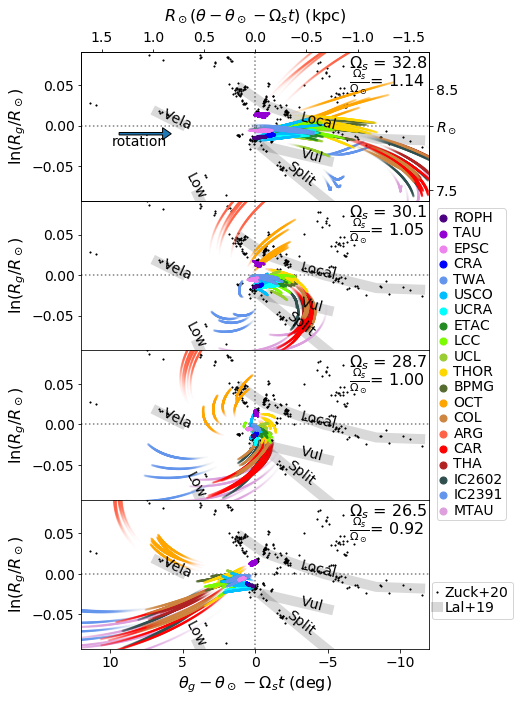

In [63]:
# make ln r theta plots but rotating with a particular pattern speeds Omega_s, in an array
# here df is the stellar association table,
# npoints is the number of integrations per stellar association
# Gcon is the structure containing galactic constants
# only show points with age within [age_min,age_max)
# only plot points within (zmin,zmax)
def lomplotpanels(Omega_s_arr,age_min,age_max,npoints,df,Gcon,zmin,zmax,figname):
    nnom = len(Omega_s_arr)
    fig,axarr = plt.subplots(nnom,1,sharex=True,sharey=True,figsize=(7,10))
    plt.subplots_adjust(left=0.15, bottom=0.10, right=0.84, top=0.93, wspace=0, hspace=0)
    rgba_colors = np.zeros((301,4))  # color list including alpha
    plt.autoscale(False)
    axarr[0].set_xlim([12,-12])  #x limits!
    lnsol = np.log(Gcon.R0)
    axarr[0].set_ylim([np.log(7.4)-lnsol,np.log(8.9)-lnsol])  # y limits
    xmin, xmax = axarr[0].get_xlim()
    ymin, ymax = axarr[0].get_ylim()
    print(ymin,ymax)
    todeg = 180.0/np.pi
    
    # loop over associations for labelling
    for isa in range(len(df.X)):
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        axarr[0].scatter(0,0,color=rgba,s=2,label=df['name'][isa])  # for labelling
    # loop over pattern speeds
    for k in range(nnom):
        axarr[k].plot([xmin,xmax],[0,0],':',color='grey',zorder=1)
        axarr[k].plot([0,0],[ymin,ymax],':',color='grey',zorder=1)
        for isa in range(len(df.X)-1,-1,-1): # go from oldest to youngest
            rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
            for j in range(npoints):   # number of integrations
                rgba_colors[:,0]=rgba[0]
                rgba_colors[:,1]=rgba[1]
                rgba_colors[:,2]=rgba[2]
                i_output = back_integrate_sa(df,isa,Gcon,1,npts_integrated)  # integrate
                
                rgba_colors[:,3]=i_output.aw_arr
                iia = (np.abs(i_output.t_arr) >= age_min/1e3) & (np.abs(i_output.t_arr) < age_max/1e3)
                iib = (i_output.z_arr > zmin) & (i_output.z_arr < zmax) 
                #print(ii)
                ii  = iia & iib
                lnr = np.log(i_output.r_arr[ii]/Gcon.R0)
                #if (j==0) and (k==0):
                #    axarr[k].scatter(0,0,color=rgba,s=1,label=df['name'][isa])
                thetadeg = (i_output.dtheta_arr[ii] - Omega_s_arr[k]*i_output.t_arr[ii])*todeg
                axarr[k].scatter(thetadeg,lnr,color=rgba_colors[ii],s=2,zorder=2)     
      
        # features from lallemont+19
        alphalev=0.15
        axarr[k].plot((thetal_arr - Gcon.theta_sun)*todeg,np.log(rl_arr/Gcon.R0),'k-',\
                      lw=10,alpha=alphalev,zorder=1)
        axarr[k].plot((thetav_arr - Gcon.theta_sun)*todeg,np.log(rv_arr/Gcon.R0),'k-',\
                      lw=10,alpha=alphalev,zorder=1)
        axarr[k].plot(residual_arr(thetals_arr - Gcon.theta_sun)*todeg,np.log(rls_arr/Gcon.R0),'k-',\
                      lw=10,alpha=alphalev,zorder=1)
        axarr[k].plot((thetavela_arr + Gcon.theta_sun)*todeg,np.log(rvela_arr/Gcon.R0),'k-',\
                      lw=10,alpha=alphalev,zorder=1)
        dtheta = residual_arr(thetalow_arr - Gcon.theta_sun)
        axarr[k].plot(dtheta*todeg,np.log(rlow_arr/Gcon.R0),'k-',\
                      lw=10,alpha=alphalev,zorder=1)
        axarr[k].text(-3,-0.005,'Local',rotation=-14,fontsize=14)
        axarr[k].text(-3,-0.045,'Vul',rotation=-15,fontsize=14)
        axarr[k].text(-2.0,-0.075,'Split',rotation=-38,fontsize=14)
        axarr[k].text(6.5,-0.005,'Vela',rotation=-25,fontsize=14)
        axarr[k].text(5.0,-0.09,'Low',rotation=-62,fontsize=14)
        dtheta = residual_arr(df_zu20['theta_g'] - Gcon.theta_sun)
        lnr = np.log(df_zu20['R_g']/Gcon.R0)  #plot zucker+20 molecular clouds
        ii  = (df_zu20['z_g'] > zmin) & (df_zu20['z_g'] < zmax) 
        axarr[k].plot(dtheta[ii]*todeg,lnr[ii],'kD',ms=1,zorder=1)
                                                                 
    for k in range(nnom):
        axarr[k].set_ylabel(r'$\ln (R_g/R_\odot)$',fontsize=16);   
        ostring1 = r'$\Omega_s$ = {:.1f}'.format(np.abs(Omega_s_arr[k]))
        xoo = xmax-(xmax-xmin)*0.23
        axarr[k].text(xoo,ymax - (ymax-ymin)/9,ostring1,fontsize=16)
        ostring2 = r'$\frac{\Omega_s}{\Omega_\odot}$' + '= {:.2f}'.format(np.abs(Omega_s_arr[k]/Gcon.om0))
        axarr[k].text(xoo,ymax - 2.1*(ymax-ymin)/9,ostring2,fontsize=16)
           
    axarr[nnom-1].set_xlabel(r'$\theta_g - \theta_\odot - \Omega_s t$ (deg)',fontsize=16);      
    #ax2 = axarr[0].twiny()  # share y axis
    axarr[0].arrow(9.4,-0.01,-3.0,0,head_width=0.015,head_length=0.6,width=0.003)
    axarr[0].text(8,-0.02,'rotation',fontsize=14,ha='center',va='center')
    
    axtop = axarr[0].twiny()  # share y axis
    axtop.set_xlim(xmin*Gcon.R0/todeg,xmax*Gcon.R0/todeg)
    axtop.set_xlabel(r'$R_\odot(\theta - \theta_\odot - \Omega_s t)$ (kpc)',fontsize=16,labelpad=10);
    
    axright = axarr[0].twinx()
    axright.set_ylim(ymin,ymax,auto=False)
    y_0 = 0.0; label_0 = r'$R_\odot$' 
    y_1 = np.log(8.5/Gcon.R0); label_1 = '8.5'
    y_2 = np.log(7.5/Gcon.R0); label_2 = '7.5'
    axright.set_yticks([y_2,y_0,y_1])#,[label_0,label_1])
    axright.set_yticklabels([label_2,label_0,label_1])
    
           
    axarr[0].legend(ncol=1,markerscale=5.,borderpad=0.2,labelspacing=0.1,\
                handlelength=0.5,handletextpad=0.5,columnspacing=0.5,fontsize=14,\
                loc="upper right",bbox_to_anchor=(1.24,0))
    axarr[nnom-1].plot(0,0,'kD',ms=1,zorder=1,label='Zuck+20')
    axarr[nnom-1].plot([0,0],[-10,-10.1],'k-',lw=10,alpha=alphalev,zorder=1,label='Lal+19')
    axarr[nnom-1].legend(ncol=1,markerscale=1,fontsize=14,bbox_to_anchor=(1.26,0.5),loc="upper right",\
                        handlelength=0.1,handletextpad=0.5,borderpad=0.3,labelspacing=0.1)
    
    if (len(figname)>3):
        plt.savefig(figname,dpi=400)
        


age_min = 0; age_max = 3000;   # age range in Myr
npoints=5; 
figname='lom_all_new.png';
dom=0.8
#Omega_s_arr = fill_Omega_s_arr(-2,dom,5,Gcon)   # array of pattern speeds

Omega_s_arr = [-32.8,-30.1,-28.7,-26.5]
for Om in Omega_s_arr:
    print('Om_s/Om_0={:.2f}'.format(Om/-Gcon.om0))
zmin=-10; zmax=10  #kpc

lomplotpanels(Omega_s_arr,age_min,age_max,npoints,df,Gcon,zmin,zmax,figname)

[7.5  7.66 7.82 7.98 8.14 8.3 ]


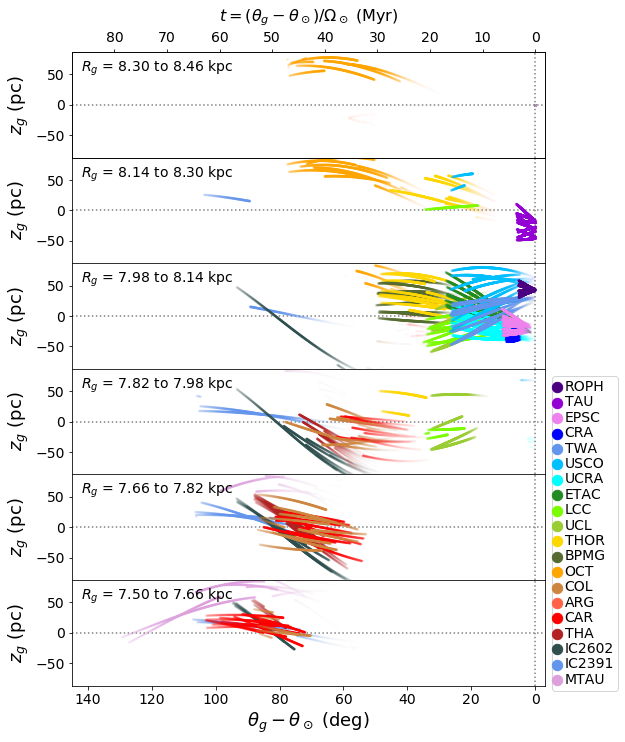

In [60]:
# make r z plots  only include points within [age_min,age_max)
# plot panels with Rg ranges
# here df is the stellar association table,
# npoints is the number of integrations per stellar association
# Gcon is the structure containing galactic constants
# calls back-integrate_sa()
def fourplotthetaz(age_min,age_max,npoints,df,Gcon,rg_arr,leg,figname):
    nr = len(rg_arr)
    dRg = rg_arr[1]-rg_arr[0]
    fig,axarr = plt.subplots(nr,1,sharex=True,sharey=True,figsize=(9,11))
    plt.subplots_adjust(left=0.12, bottom=0.11, right=0.85, top=0.91, wspace=0, hspace=0)
    
    rgba_colors = np.zeros((npts_integrated,4))  # color list including alpha
    
    todeg = 180.0/np.pi   # convert angles to degrees
    axarr[nr-1].set_xlabel(r'$\theta_g - \theta_\odot$ (deg)',fontsize=18); 
    zmaxr = 87
    axarr[0].set_ylim([-zmaxr,zmaxr])
    axarr[0].set_xlim([145,-3])
    xmin, xmax = axarr[0].get_xlim()
    ymin, ymax = axarr[0].get_ylim()
    
    for k in range(nr):
        axarr[k].set_ylabel(r'$z_g$ (pc)',fontsize=18)
        axarr[k].plot([xmin,xmax],[0,0],':',color='grey',zorder=1)
        axarr[k].plot([0,0],[ymin,ymax],':',color='grey',zorder=1)
        rstring = r'$R_g$ = {:.2f} to {:.2f} kpc'.format(rg_arr[k],rg_arr[k]+dRg)
        axarr[nr-k-1].text(142,55,rstring,fontsize=14)
    
    for isa in range(len(df.X)): 
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        axarr[0].scatter(0,0,color=rgba,s=3,label=df['name'][isa])  #labels
        
    for isa in range(len(df.X)-1,-1,-1): # go from oldest to youngest
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        for j in range(npoints):   # number of integrations
            rgba_colors[:,0]=rgba[0]
            rgba_colors[:,1]=rgba[1]
            rgba_colors[:,2]=rgba[2]
            i_output = back_integrate_sa(df,isa,Gcon,1,npts_integrated) # do integration
            rgba_colors[:,3]=i_output.aw_arr
            iia = (np.abs(i_output.t_arr) >= age_min/1e3) & (np.abs(i_output.t_arr) < age_max/1e3)
            for k in range(nr):
                iib = (i_output.r_arr >= rg_arr[k]) & (i_output.r_arr < rg_arr[k] + dRg)
                ii = iia & iib
                axarr[nr-k-1].scatter(i_output.dtheta_arr[ii]*todeg,i_output.z_arr[ii]*1e3,color=rgba_colors[ii],\
                                 s=3,zorder=2)
    
    if (leg==1):
        axarr[0].legend(ncol=1,markerscale=6,fontsize=14,bbox_to_anchor=(1.17,-2.0),loc="upper right",\
                        handlelength=0.1,handletextpad=0.5,borderpad=0.3,labelspacing=0.1)
    
    # top axis
    ax2 = axarr[0].twiny()  # share y axis
    t1 = xmin/todeg / Gcon.om0 *1e3  # should be time in Myr
    t2 = xmax/todeg / Gcon.om0 *1e3  
    ax2.set_xlim(t1,t2)
    ax2.set_xlabel(r'$t =(\theta_g - \theta_\odot)/\Omega_\odot$ (Myr)',fontsize=16,labelpad=10);
    
    if (len(figname)>3):
        plt.savefig(figname,dpi=300)
        

age_min = 0; age_max = 3000;   # age range in Myr
npoints=10
figname='thetaz_all_r4.png'
rg_arr = np.linspace(7.5,8.3,6) # last number is number of panels
leg=1
fourplotthetaz(age_min,age_max,npoints,df,Gcon,rg_arr,leg,figname)
print(rg_arr)

In [ ]:
# fill an array of omegas
# ii  is shift of first one
# dom is spacing
# nom is number of omegas
def fill_Omega_s_arr(ii,dom,nom,Gcon):
    Omega_s_arr = np.zeros(nom)
    for j in range(nom):
        Omega_s_arr[j]  = -Gcon.om0 + (ii+j)*dom
    return Omega_s_arr 

In [178]:
# make ln r theta plots but rotating with a particular pattern speed Omega_s, in an dzarray
# here df is the stellar association table,
# npoints is the number of integrations per stellar association
# Gcon is the structure containing galactic constants
# only show points with age within [age_min,age_max)
# only plot points within (zmin,zmax) 4 panels of range 
def lomz4(Omega_s,age_min,age_max,npoints,df,Gcon,zmin_arr,ylims,tlims,leg,figname):
    nz = len(zmin_arr)
    dz = zmin_arr[1] - zmin_arr[0]
    fig,axarr = plt.subplots(nz,1,sharex=True,sharey=True,figsize=(7,10))
    plt.subplots_adjust(left=0.15, bottom=0.10, right=0.84, top=0.93, wspace=0, hspace=0)
    rgba_colors = np.zeros((301,4))  # color list including alpha
    lnsol = np.log(Gcon.R0)
    
    axarr[0].set_xlim(tlims)  # theta
    #axarr[0].set_ylim([np.log(7.4)-lnsol,np.log(8.8)-lnsol])  #log R
    axarr[0].set_ylim(ylims)  #log R
    xmin, xmax = axarr[0].get_xlim()
    ymin, ymax = axarr[0].get_ylim()
    todeg = 180.0/np.pi
    xoo = xmin + (xmax-xmin)*0.015
    yoo  = ymax - (ymax-ymin)*0.12
    yoo2 = ymax + (ymax-ymin)*0.04

    # loop over associations for labelling
    for isa in range(len(df.X)):
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        axarr[0].scatter(0,0,color=rgba,s=2,label=df['name'][isa])  # for labelling
    
    
    # loop over z panels
    for k in range(nz):
        axarr[k].plot([xmin,xmax],[0,0],':',color='grey',zorder=1)
        axarr[k].plot([0,0],[ymin,ymax],':',color='grey',zorder=1)
        axarr[k].set_ylabel(r'$\ln (R_g/R_\odot)$',fontsize=16);   
        zb = zmin_arr[k]
        ostring = r'$z_g$={:.0f} to {:.0f} pc'.format(zb*1e3,(zb+dz)*1e3)
        axarr[nz-k-1].text(xoo,yoo,ostring,fontsize=14)
    # loop over associations
    for isa in range(len(df.X)-1,-1,-1): # go from oldest to youngest
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        for j in range(npoints):   # number of integrations
            rgba_colors[:,0]=rgba[0]
            rgba_colors[:,1]=rgba[1]
            rgba_colors[:,2]=rgba[2]
            i_output = back_integrate_sa(df,isa,Gcon,1,npts_integrated)  #integrate
                
            rgba_colors[:,3]=i_output.aw_arr
            iia = (np.abs(i_output.t_arr) >= age_min/1e3) & (np.abs(i_output.t_arr) < age_max/1e3)
            for k in range(nz):
                iib = (i_output.z_arr > zmin_arr[k]) & (i_output.z_arr < zmin_arr[k] + dz) 
                #print(ii)
                ii  = iia & iib
                lnr = np.log(i_output.r_arr[ii]/Gcon.R0)
                #if (j==0) and (k==0):
                #    axarr[k].scatter(0,0,color=rgba,s=1,label=df['name'][isa])
                thetadeg = (i_output.dtheta_arr[ii] - Omega_s*i_output.t_arr[ii])*todeg
                axarr[nz-k-1].scatter(thetadeg,lnr,color=rgba_colors[ii],s=2,zorder=2)     
      
    
    # zucker+20 molecular clouds
    dtheta_zu = residual_arr(df_zu20['theta_g'] - Gcon.theta_sun)
    lnr_zu = np.log(df_zu20['R_g']/Gcon.R0)  
    
    for k in range(nz):   
        # features from lallemont+19
        alphalev=0.15
        axarr[k].plot((thetal_arr - Gcon.theta_sun)*todeg,np.log(rl_arr/Gcon.R0),'k-',\
                      lw=10,alpha=alphalev,zorder=1)
        axarr[k].plot((thetav_arr - Gcon.theta_sun)*todeg,np.log(rv_arr/Gcon.R0),'k-',\
                      lw=10,alpha=alphalev,zorder=1)
        axarr[k].plot(residual_arr(thetals_arr - Gcon.theta_sun)*todeg,np.log(rls_arr/Gcon.R0),'k-',\
                      lw=10,alpha=alphalev,zorder=1)
        axarr[k].plot((thetavela_arr + Gcon.theta_sun)*todeg,np.log(rvela_arr/Gcon.R0),'k-',\
                      lw=10,alpha=alphalev,zorder=1)
        dtheta = residual_arr(thetalow_arr - Gcon.theta_sun)
        axarr[k].plot(dtheta*todeg,np.log(rlow_arr/Gcon.R0),'k-',\
                      lw=10,alpha=alphalev,zorder=1)
        if (xmax < -3.1):
            axarr[k].text(-3,-0.005,'Local',rotation=-14,fontsize=14)
            axarr[k].text(-3,-0.045,'Vul',rotation=-15,fontsize=14)
            axarr[k].text(-3,-0.08,'Split',rotation=-15,fontsize=14)
        if (xmax < -2.1) and (xmax > -3.1):
            axarr[k].text(-2,-0.005+0.01,'Local',rotation=-14,fontsize=14)
            axarr[k].text(-2,-0.045+0.01,'Vul',rotation=-15,fontsize=14)
            axarr[k].text(-1.2,-0.07+0.02,'Split',rotation=-20,fontsize=14)
        if (xmax > -2.1):
            axarr[k].text(-1,-0.005+0.01,'Local',rotation=-14,fontsize=14)
            axarr[k].text(-1,-0.045+0.01,'Vul',rotation=-15,fontsize=14)
            axarr[k].text(-1.2,-0.07+0.02,'Split',rotation=-20,fontsize=14)
        if (xmin > 5):
            axarr[k].text(6.5,-0.005,'Vela',rotation=-25,fontsize=14)
        if (xmin > 6):
            axarr[k].text(4.5,-0.09,'Low',rotation=-62,fontsize=14)
        
        # zucker+20 clouds
        ii  = (df_zu20['z_g'] > zmin_arr[k]) & (df_zu20['z_g'] < zmin_arr[k]+dz) 
        axarr[k].plot(dtheta_zu[ii]*todeg,lnr_zu[ii],'kD',ms=3,zorder=5)
    
    ostring1 = r'$\Omega_s$ = {:.1f}, '.format(np.abs(Omega_s))
    ostring2 = r'$\Omega_s/\Omega_0$ = {:.2f}'.format(np.abs(Omega_s/Gcon.om0))
    axarr[0].text(xoo,yoo2,ostring1+ostring2,fontsize=18)
    axarr[nz-1].set_xlabel(r'$\theta_g - \theta_\odot - \Omega_s t$ (deg)',fontsize=16);      
    #axarr[0].arrow(9.4,-0.01,-3.0,0,head_width=0.015,head_length=0.6,width=0.003)
    #axarr[0].text(8,-0.02,'rotation',fontsize=14,ha='center',va='center')
   
    if (leg==1):
        axarr[0].legend(ncol=1,markerscale=5.,borderpad=0.2,labelspacing=0.1,\
                handlelength=0.5,handletextpad=0.5,columnspacing=0.5,fontsize=14,\
                loc="upper right",bbox_to_anchor=(1.24,1))
    axarr[nz-1].plot(0,-100,'kD',ms=3,zorder=1,label='Zuck+20')
    axarr[nz-1].plot([0,0],[-100,-100.1],'k-',lw=10,alpha=alphalev,zorder=1,label='Lal+19')  #labelling
    if (leg==1):
        axarr[nz-1].legend(ncol=1,markerscale=1,fontsize=14,bbox_to_anchor=(1.26,1),loc="upper right",\
                        handlelength=0.1,handletextpad=0.5,borderpad=0.3,labelspacing=0.1)
    
    if (len(figname)>3):
        plt.savefig(figname,dpi=300)
        
    return 

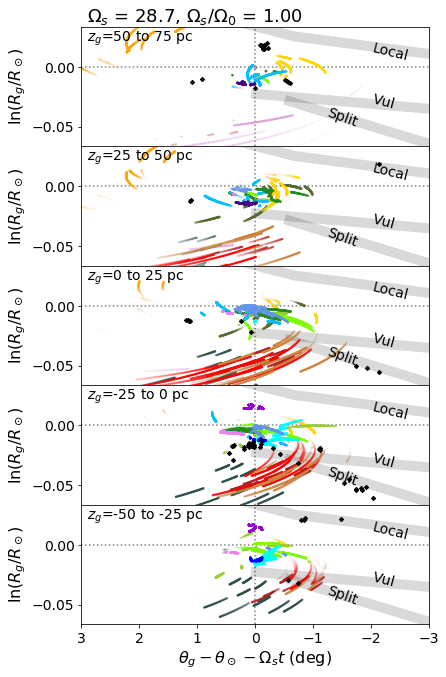

In [179]:
age_min = 0; age_max = 3000;   # age range in Myr
npoints=10; 
Omega_s = -28.7  # pattern speed
zmin_arr=np.arange(-0.050,0.075,0.025)  # last number is dz 
figname = 'lomz4_med.png'
leg=0; tlims = [3,-3] # theta limits
lnsol = np.log(Gcon.R0)
ylims =[np.log(7.6)-lnsol,np.log(8.4)-lnsol]  #log R
lomz4(Omega_s,age_min,age_max,npoints,df,Gcon,zmin_arr,ylims,tlims,leg,figname)

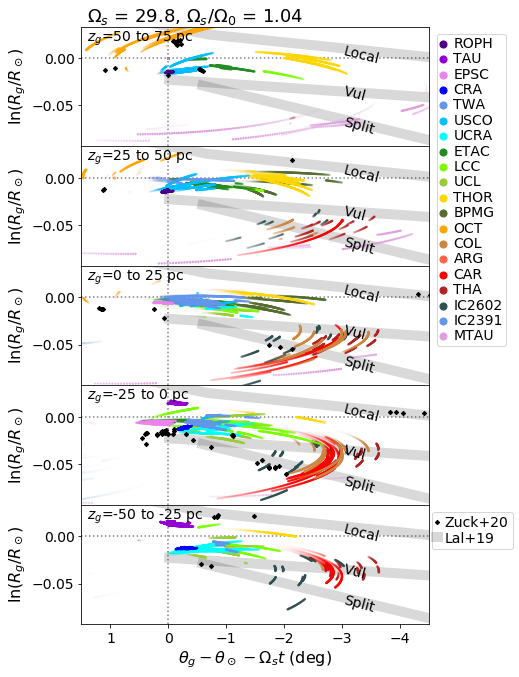

In [180]:
age_min = 0; age_max = 3000;   # age range in Myr
npoints=10; 
Omega_s = -29.8   # pattern speed
zmin_arr=np.arange(-0.050,0.075,0.025)  # last number is dz 
figname = 'lomz4_fast.png'
leg=1; tlims = [1.5,-4.5] # theta limits
lnsol = np.log(Gcon.R0)
ylims =[np.log(7.4)-lnsol,np.log(8.4)-lnsol]  #log R
lomz4(Omega_s,age_min,age_max,npoints,df,Gcon,zmin_arr,ylims,tlims,leg,figname)

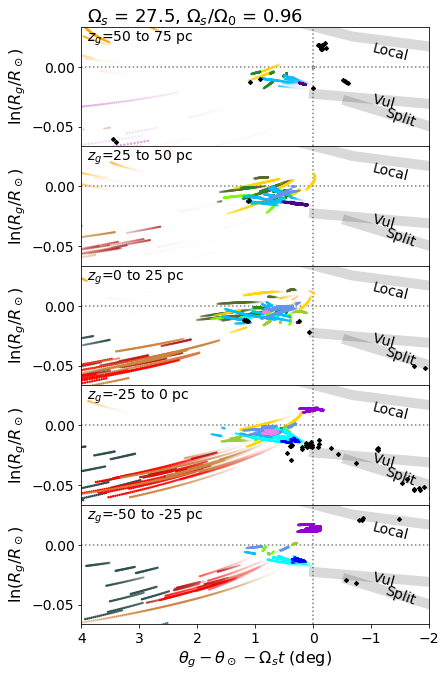

In [182]:
age_min = 0; age_max = 3000;   # age range in Myr
npoints=10; 
Omega_s = -27.5  # pattern speed
zmin_arr=np.arange(-0.050,0.075,0.025)  # last number is dz 
figname = 'lomz4_slow.png'
leg=0; tlims = [4,-2] # theta limits
lnsol = np.log(Gcon.R0)
ylims =[np.log(7.6)-lnsol,np.log(8.4)-lnsol]  #log R
lomz4(Omega_s,age_min,age_max,npoints,df,Gcon,zmin_arr,ylims,tlims,leg,figname)

In [123]:
# make ln r theta plots but rotating with a particular pattern speed Omega_s, in an Rarray
# here df is the stellar association table,
# npoints is the number of integrations per stellar association
# Gcon is the structure containing galactic constants
# only show points with age within [age_min,age_max)
# only plot points within (range of rs) 4 panels of range 
def lomr4(Omega_s,age_min,age_max,npoints,df,Gcon,rg_arr,ylims,tlims,leg,figname):
    nR = len(rg_arr)
    dR = rg_arr[1] - rg_arr[0]
    fig,axarr = plt.subplots(nR,1,sharex=True,sharey=True,figsize=(7,10))
    plt.subplots_adjust(left=0.15, bottom=0.10, right=0.84, top=0.93, wspace=0, hspace=0)
    rgba_colors = np.zeros((301,4))  # color list including alpha
    lnsol = np.log(Gcon.R0)
    
    #axarr[0].set_xlim([9.9,-7])  # theta
    #axarr[0].set_ylim([-90,90])  #z range
    
    axarr[0].set_xlim(tlims)  # theta
    axarr[0].set_ylim(ylims)  #log R
    
    xmin, xmax = axarr[0].get_xlim()
    ymin, ymax = axarr[0].get_ylim()
    todeg = 180.0/np.pi
    xoo  = xmin + (xmax-xmin)*0.015
    yoo  = ymax - (ymax-ymin)*0.12
    yoo2 = ymax + (ymax-ymin)*0.04

    # loop over associations for labelling
    for isa in range(len(df.X)):
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        axarr[0].scatter(0,0,color=rgba,s=2,label=df['name'][isa])  # for labelling
 
    #zucker+20 molecular clouds
    dtheta_zu = residual_arr(df_zu20['theta_g'] - Gcon.theta_sun)
    #lnr_zu = np.log(df_zu20['R_g']/Gcon.R0)  
    
    # loop over R panels
    for k in range(nR):
        axarr[k].plot([xmin,xmax],[0,0],':',color='grey',zorder=1)
        axarr[k].plot([0,0],[ymin,ymax],':',color='grey',zorder=1)
        axarr[k].set_ylabel(r'$z_g (pc)$',fontsize=16);   
        rb = rg_arr[k]
        ostring = r'$R_g$={:.2f} to {:.2f} kpc'.format(rb,(rb+dR))
        axarr[nR-k-1].text(xoo,yoo,ostring,fontsize=14)
        ii  = (df_zu20['R_g'] > rg_arr[k]) & (df_zu20['R_g'] < rg_arr[k]+dR) 
        axarr[k].plot(dtheta_zu[ii]*todeg,df_zu20['z_g'][ii]*1e3,'kD',ms=3,zorder=1)
        
    # loop over associations
    for isa in range(len(df.X)-1,-1,-1): # go from oldest to youngest
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        for j in range(npoints):   # number of integrations
            rgba_colors[:,0]=rgba[0]
            rgba_colors[:,1]=rgba[1]
            rgba_colors[:,2]=rgba[2]
            i_output = back_integrate_sa(df,isa,Gcon,1,npts_integrated)  #integrate
                
            rgba_colors[:,3]=i_output.aw_arr
            iia = (np.abs(i_output.t_arr) >= age_min/1e3) & (np.abs(i_output.t_arr) < age_max/1e3)
            for k in range(nR):
                iib = (i_output.r_arr > rg_arr[k]) & (i_output.r_arr < rg_arr[k] + dR) 
                #print(ii)
                ii  = iia & iib
                #lnr = np.log(i_output.r_arr[ii]/Gcon.R0)
                #if (j==0) and (k==0):
                #    axarr[k].scatter(0,0,color=rgba,s=1,label=df['name'][isa])
                thetadeg = (i_output.dtheta_arr[ii] - Omega_s*i_output.t_arr[ii])*todeg
                axarr[nR-k-1].scatter(thetadeg,i_output.z_arr[ii]*1e3,color=rgba_colors[ii],s=2,zorder=2)     
      
        
    ostring = r'$\Omega_s/\Omega_0$ = {:.2f}'.format(np.abs(Omega_s/Gcon.om0))
    axarr[0].text(xoo,yoo2,ostring,fontsize=16)
    axarr[nR-1].set_xlabel(r'$\theta_g - \theta_\odot - \Omega_s t$ (deg)',fontsize=16);      
    #axarr[0].arrow(9.4,-0.01,-3.0,0,head_width=0.015,head_length=0.6,width=0.003)
    #axarr[0].text(8,-0.02,'rotation',fontsize=14,ha='center',va='center')
   
    if (leg==1):
        axarr[0].legend(ncol=1,markerscale=5.,borderpad=0.2,labelspacing=0.1,\
                handlelength=0.5,handletextpad=0.5,columnspacing=0.5,fontsize=14,\
                loc="upper right",bbox_to_anchor=(1.24,1))
        axarr[nR-1].plot(0,-100,'kD',ms=3,zorder=1,label='Zuck+20')
    #axarr[nz-1].plot([0,0],[-100,-100.1],'k-',lw=10,alpha=alphalev,zorder=1,label='Lal+19')  #labelling
    if (leg==1):
        axarr[nR-1].legend(ncol=1,markerscale=1,fontsize=14,bbox_to_anchor=(1.26,1),loc="upper right",\
                        handlelength=0.1,handletextpad=0.5,borderpad=0.3,labelspacing=0.1)
    
    if (len(figname)>3):
        plt.savefig(figname,dpi=300)
        
    return fig,axarr


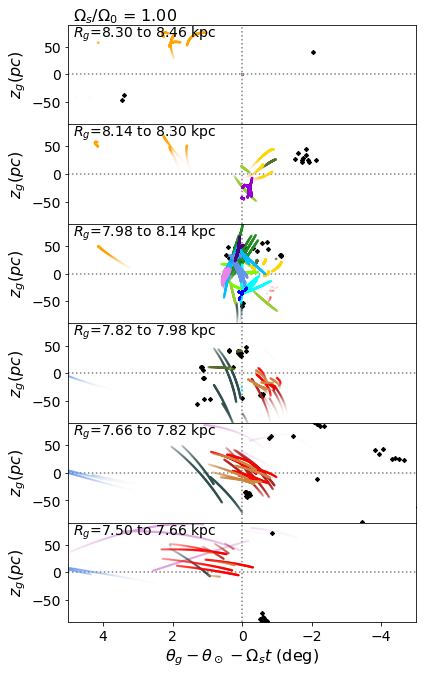

In [124]:
age_min = 0; age_max = 3000;   # age range in Myr
npoints=5; 
Omega_s = Omega_s_arr[2]   # pattern speed
rg_arr = np.linspace(7.5,8.3,6)
leg=0; tlims = [5,-5] # theta limits
ylims =[-90,90]
figname = 'lomr4_med.png'
fig,axarr = lomr4(Omega_s,age_min,age_max,npoints,df,Gcon,rg_arr,ylims,tlims,leg,figname)

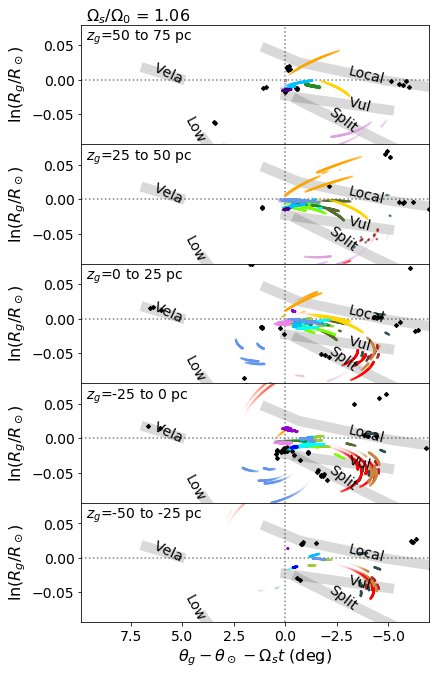

In [246]:
age_min = 0; age_max = 3000;   # age range in Myr
npoints=5; 
Omega_s = Omega_s_arr[0]   # pattern speed
zmin_arr=np.arange(-0.050,0.075,0.025)  # last number is dz 
figname = 'lomz4_fast.png'
fig,axarr = lomz4(Omega_s,age_min,age_max,npoints,df,Gcon,zmin_arr,ylims,tlims,0,figname)

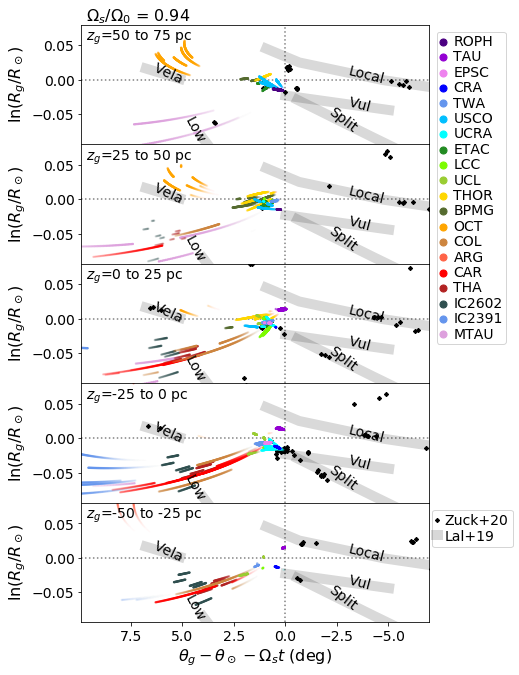

In [248]:
age_min = 0; age_max = 3000;   # age range in Myr
npoints=5; 
Omega_s = Omega_s_arr[4]   # pattern speed
zmin_arr=np.arange(-0.050,0.075,0.025)  # last number is dz 
figname = 'lomz4_slow.png'
fig,axarr = lomz4(Omega_s,age_min,age_max,npoints,df,Gcon,zmin_arr,ylims,tlims,1,figname)

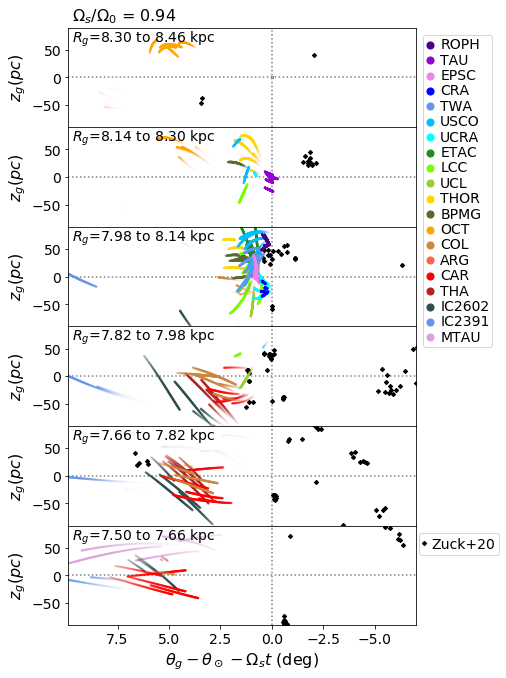

In [251]:
Omega_s = Omega_s_arr[4]   # pattern speed
figname = 'lomr4_slow.png'
fig,axarr = lomr4(Omega_s,age_min,age_max,npoints,df,Gcon,rg_arr,1,figname)

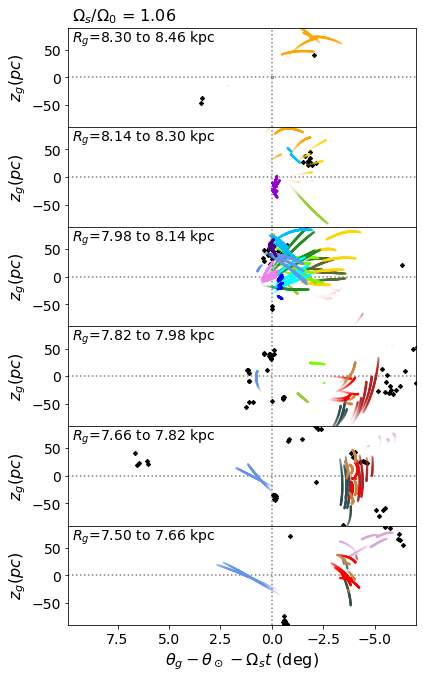

In [252]:
Omega_s = Omega_s_arr[0]   # pattern speed
figname = 'lomr4_fast.png'
fig,axarr = lomr4(Omega_s,age_min,age_max,npoints,df,Gcon,rg_arr,0,figname)

In [84]:
# find a median zmax and std of this
# vertical amplitudes of these stellar associations
# errors using using orbital spread set by efac, tmax=-0.6 Gyr
# returns units in pc
# zmax does not care about age, so no age weighting here
def med_zmax(df,npoints,Gcon,efac):
    tmax = -0.6 # in Gyr
    #efac = 0.1  # how much randomness to add to initial conditions
    zmed_arr = []
    zsig_arr = []
    e_arr = []
    esig_arr =[]
    for isa in range(len(df.X)):
        zlist  = []
        rmaxlist = []
        rminlist = []
        #drlist =[]
        for j in range(npoints):
            i_output = back_integrate_sa_tmax(df,isa,Gcon,efac,npts_integrated*6,tmax) 
            # do integration
            zm = max(np.abs(i_output.z_arr))
            zlist = np.append(zlist,zm)
            rmax = max(i_output.r_arr); rmin = min(i_output.r_arr)
            rmaxlist = np.append(rmaxlist,rmax)
            rminlist = np.append(rminlist,rmin)
            #drlist = np.append(drlist,rmax - rmin)
        zmed = np.median(zlist)
        zsig = np.std(zlist)
        zmed_arr = np.append(zmed_arr,zmed*1e3) # returns in pc
        zsig_arr = np.append(zsig_arr,zsig*1e3)
        eelist = (rmaxlist - rminlist)/(rmaxlist + rminlist)
        emed = np.median(eelist)
        esig = np.std(eelist)
        e_arr = np.append(e_arr,emed) 
        esig_arr = np.append(esig_arr,esig)
        #print('{:.1f} {:.1f} {:s} {:.0f}'.format(zmed*1e3,zsig*1e3,df['name'][isa],df['age'][isa]))
    return zmed_arr,zsig_arr,e_arr,esig_arr
 
npoints=8; efac=0.1
zmed_arr_small,zsig_arr_small,e_arr_small,esig_arr_small = med_zmax(df,npoints,Gcon,efac)
efac=1.
zmed_arr_one,zsig_arr_one,e_arr_one,esig_arr_one = med_zmax(df,npoints,Gcon,efac)
for isa in range(len(df.X)):
    print('{:5.1f} {:4.1f} {:5.1f} {:4.1f} {:7.4f} {:7.4f} {:7.4f} {:7.4f} {:7s} {:2.0f}'.format(\
                zmed_arr_small[isa],zsig_arr_small[isa],\
                zmed_arr_one[isa],zsig_arr_one[isa],\
                e_arr_small[isa],esig_arr_small[isa],\
                e_arr_one[isa],esig_arr_one[isa],\
                df['name'][isa],df['age'][isa]))
    


 44.5  2.0  55.6 40.8  0.0172  0.0006  0.0228  0.0070 ROPH     1
 38.0  2.1  51.6 47.9  0.0159  0.0012  0.0281  0.0072 TAU      2
 45.1  2.0  59.5 22.9  0.0303  0.0009  0.0294  0.0086 EPSC     4
 44.9  1.9  40.6  6.6  0.0266  0.0004  0.0331  0.0075 CRA      4
 40.0  1.7  42.4 19.1  0.0244  0.0004  0.0239  0.0038 TWA     10
 55.6  1.0  66.8 11.0  0.0213  0.0011  0.0222  0.0116 USCO    10
 35.2  0.9  37.8  6.6  0.0307  0.0010  0.0351  0.0078 UCRA    10
 74.4  2.2  88.5 25.5  0.0441  0.0007  0.0409  0.0130 ETAC    11
 20.9  3.0  36.9 16.0  0.0399  0.0012  0.0462  0.0099 LCC     15
 45.8  2.4  56.1 14.4  0.0374  0.0005  0.0379  0.0113 UCL     16
 32.4  1.9  52.5 20.4  0.0291  0.0010  0.0296  0.0108 THOR    22
 27.7  1.6  28.1 13.3  0.0161  0.0006  0.0171  0.0035 BPMG    24
 69.9  1.9  68.9 17.4  0.0388  0.0007  0.0361  0.0056 OCT     35
 28.6  0.8  24.0  6.4  0.0390  0.0005  0.0424  0.0058 COL     42
 32.9  2.3  63.0 27.9  0.1162  0.0009  0.1144  0.0090 ARG     45
 28.6  1.4  30.9 17.7  0.

In [85]:
# find means and errs with many initial conditions
# errors using age spread of 0 but using orbital spread set by efac, 
# returns units in kpc, km/s
# npts_integrated is a global for number of points in time 
def birth_varinit(df,npoints,Gcon,efac):
    nn = len(df.X)
    
    # errors and means from orbits
    zbo_arr = np.zeros(nn); ezbo_arr = np.zeros(nn) 
    vzbo_arr = np.zeros(nn); evzbo_arr = np.zeros(nn)
    Rbo_arr = np.zeros(nn); eRbo_arr = np.zeros(nn)
    vrbo_arr = np.zeros(nn); evrbo_arr = np.zeros(nn)
    tbo_arr = np.zeros(nn); etbo_arr = np.zeros(nn)
    Lo_arr = np.zeros(nn); eLo_arr = np.zeros(nn)
    
    #tmax = -0.6 # in Gyr
    #efac = 0.1  # how much randomness to add to initial conditions
    zmed_arr = []
    zsig_arr = []
    for isa in range(len(df.X)):
        zlist  = []; Rlist = []; vzlist = []; vrlist = []; tlist = []; Llist = [];
        for j in range(npoints):
            i_output = back_integrate_sa(df,isa,Gcon,efac,npts_integrated*2) 
            # do integration
            ii = np.argmin(np.abs(np.abs(i_output.t_arr)*1e3 - df['age'][isa]))
            zlist =  np.append(zlist,i_output.z_arr[ii])
            Rlist = np.append(Rlist,i_output.r_arr[ii])
            vzlist = np.append(vzlist,i_output.w_arr[ii])
            vrlist = np.append(vrlist,-i_output.u_arr[ii])
            tlist = np.append(tlist,i_output.dtheta_arr[ii])
            Llist = np.append(Llist,np.abs(i_output.v_arr[ii])*i_output.r_arr[ii])
        zbo_arr[isa] = np.median(zlist); ezbo_arr[isa] = np.std(zlist)
        Rbo_arr[isa] = np.median(Rlist); eRbo_arr[isa] = np.std(Rlist)
        vzbo_arr[isa] = np.median(vzlist); evzbo_arr[isa] = np.std(vzlist)
        vrbo_arr[isa] = np.median(vrlist); evrbo_arr[isa] = np.std(vrlist)
        tbo_arr[isa] = np.median(tlist); etbo_arr[isa] = np.std(tlist)
        Lo_arr[isa] = np.median(Llist); eLo_arr[isa] = np.std(Llist)
        
        #
    return zbo_arr,ezbo_arr,vzbo_arr,evzbo_arr,Rbo_arr,eRbo_arr,vrbo_arr,evrbo_arr,tbo_arr,etbo_arr,Lo_arr,eLo_arr
 
# do integrations
npoints=30; efac=1
zbo_arr,ezbo_arr,vzbo_arr,evzbo_arr,Rbo_arr,eRbo_arr,vrbo_arr,evrbo_arr,tbo_arr,etbo_arr,Lo_arr,eLo_arr\
    = birth_varinit(df,npoints,Gcon,efac)


In [87]:
# find birth locations, and estimate errors too but only for exact initial conditions and with age spread
# units returned kpc,km/s
# makes table used in paper!
def births(df,Gcon):
    nn = len(df.X)
    zb_arr = np.zeros(nn); ezb_arr = np.zeros(nn)  # from ages
    vzb_arr = np.zeros(nn); evzb_arr = np.zeros(nn)
    Rb_arr = np.zeros(nn); eRb_arr = np.zeros(nn)
    vrb_arr = np.zeros(nn); evrb_arr = np.zeros(nn)
    tb_arr = np.zeros(nn); etb_arr = np.zeros(nn)
    dtt_arr = np.zeros(nn); edtt_arr = np.zeros(nn)
    
    
    L_arr = np.zeros(nn)
    for isa in range(nn):  # loop over associations
        i_output = back_integrate_sa(df,isa,Gcon,0.0,npts_integrated*2) # do integration, no scatter
        ii = np.argmin(np.abs(np.abs(i_output.t_arr)*1e3 - df['age'][isa]))
        #print(ii)
        # values at exact age
        zb = i_output.z_arr[ii]
        Rb = i_output.r_arr[ii]
        tb = i_output.dtheta_arr[ii]
        zb_arr[isa] = i_output.z_arr[ii]
        vzb_arr[isa] = i_output.w_arr[ii]
        Rb_arr[isa] = i_output.r_arr[ii]
        vrb_arr[isa] = -i_output.u_arr[ii]
        tb_arr[isa] = i_output.dtheta_arr[ii]
        L_arr[isa] = np.abs(i_output.v_arr[ii])*i_output.r_arr[ii]  # angular momentum
        dtt_arr[isa] = i_output.dtheta_arr[ii]  - np.abs(Gcon.om0*i_output.t_arr[ii])
        # i_output.aw_arr # age weights 
        sumaw = np.sum(i_output.aw_arr)
        zbmean = np.sum(i_output.z_arr*i_output.aw_arr)/sumaw
        zb2 = np.sum(i_output.z_arr**2*i_output.aw_arr)/sumaw
        ezb_arr[isa] =np.sqrt(zb2 - zbmean**2)
        Rbmean = np.sum(i_output.r_arr*i_output.aw_arr)/sumaw
        Rb2 = np.sum(i_output.r_arr**2*i_output.aw_arr)/sumaw
        eRb_arr[isa] =np.sqrt(Rb2 - Rbmean**2)
        tbmean = np.sum(i_output.dtheta_arr*i_output.aw_arr)/sumaw
        tb2 = np.sum(i_output.dtheta_arr**2*i_output.aw_arr)/sumaw
        etb_arr[isa] =np.sqrt(tb2 - tbmean**2)
        vzbmean = np.sum(i_output.w_arr*i_output.aw_arr)/sumaw
        vzb2 = np.sum(i_output.w_arr**2*i_output.aw_arr)/sumaw
        evzb_arr[isa] =np.sqrt(vzb2 - vzbmean**2)
        vrbmean = np.sum(-i_output.u_arr*i_output.aw_arr)/sumaw
        vrb2 = np.sum(i_output.u_arr**2*i_output.aw_arr)/sumaw
        evrb_arr[isa] =np.sqrt(vrb2 - vrbmean**2)
        dttmean = np.sum((i_output.dtheta_arr  - np.abs(Gcon.om0*i_output.t_arr))*i_output.aw_arr)/sumaw
        dtt2 =  np.sum((i_output.dtheta_arr  - np.abs(Gcon.om0*i_output.t_arr))**2*i_output.aw_arr)/sumaw
        edtt_arr[isa] = np.sqrt(dtt2 - dttmean**2)
       
    return zb_arr,ezb_arr,Rb_arr,eRb_arr,tb_arr,etb_arr,vzb_arr,evzb_arr,vrb_arr,evrb_arr,L_arr
        
zb_arr,ezb_arr,Rb_arr,eRb_arr,tb_arr,etb_arr,vzb_arr,evzb_arr,vrb_arr,evrb_arr,L_arr=\
    births(df,Gcon)

#add errors in quadrature
ezb_tot_arr = np.sqrt(ezb_arr**2 + ezbo_arr**2)
eRb_tot_arr = np.sqrt(eRb_arr**2 + eRbo_arr**2)
evzb_tot_arr = np.sqrt(evzb_arr**2 + evzbo_arr**2)
evrb_tot_arr = np.sqrt(evrb_arr**2 + evrbo_arr**2)
etb_tot_arr = np.sqrt(etb_arr**2 + etbo_arr**2)

# useful rotation curve information
bexp  = (Gcon.beta-1.0)/(Gcon.beta+1.0)
om_L = Gcon.om0*(L_arr/Gcon.L0)**bexp
om_Rb = Gcon.om0*(Rb_arr/Gcon.R0)**(Gcon.beta - 1.0)
R_L = Gcon.R0*(L_arr/Gcon.L0)**(1.0/(1+ Gcon.beta))
R_Lo = Gcon.R0*(Lo_arr/Gcon.L0)**(1.0/(1+ Gcon.beta))
eR_Lo = Gcon.R0*(eLo_arr/Gcon.L0)

f = open('birth.txt', 'w') 

pstring = 'name    & $z_b$ & $v_{z,b}$ & $R_b$ & $v_{R,b}$   &$\\theta_b-\\theta_\odot$& $R_L$ & $|z|_{max}$ & eccentricity  \\\\'
print(pstring); f.write(pstring); f.write('\n')
pstring = '        & (pc)   & (km/s) & (kpc)  & (km/s)   & (rad)            & (kpc)        &  (pc) & \\\\'
print(pstring); f.write(pstring); f.write('\n')
pstring = '\\hline'
print(pstring); f.write(pstring); f.write('\n')
pstring = '{:7s} & '  #name
pstring = pstring + '${:3.0f}\\pm {:2.0f}$ & '  # zb
pstring = pstring + '${:4.1f}\\pm {:3.1f}$ & '  # vzb
pstring = pstring + '${:5.3f}\\pm {:5.3f}$ & '  # Rb
pstring = pstring + '${:4.1f}\\pm {:3.1f}$ & '  # vrb
pstring = pstring + '${:5.3f}\\pm {:5.3f}$ & '  # thetab
pstring = pstring + '${:5.3f}\\pm {:5.3f}$ & '  # R_L
pstring = pstring + '${:3.0f}\\pm {:2.0f}$ & '  # zmax
pstring = pstring + '${:7.4f}\\pm {:7.4f}$ & '  # eccentricity
pstring = pstring + '\\\\'
for isa in range(len(df.X)):
    print(pstring.format(\
            df['name'][isa],\
            zb_arr[isa]*1e3,ezb_tot_arr[isa]*1e3,\
            vzb_arr[isa],evzb_tot_arr[isa],\
            Rb_arr[isa],eRb_tot_arr[isa],\
            vrb_arr[isa],evrb_tot_arr[isa],\
            tb_arr[isa],etb_tot_arr[isa],\
            R_Lo[isa],eR_Lo[isa],\
            zmed_arr_one[isa],zsig_arr_one[isa],\
            e_arr_one[isa],esig_arr_one[isa])) 
         
    f.write(pstring.format(\
            df['name'][isa],\
            zb_arr[isa]*1e3,ezb_tot_arr[isa]*1e3,\
            vzb_arr[isa],evzb_tot_arr[isa],\
            Rb_arr[isa],eRb_tot_arr[isa],\
            vrb_arr[isa],evrb_tot_arr[isa],\
            tb_arr[isa],etb_tot_arr[isa],\
            R_Lo[isa],eR_Lo[isa],\
            zmed_arr_one[isa],zsig_arr_one[isa],\
            e_arr_one[isa],esig_arr_one[isa])) 
           
    f.write('\n')
pstring = '\\hline' 
print(pstring); f.write(pstring); f.write('\n')
f.close()
    

name    & $z_b$ & $v_{z,b}$ & $R_b$ & $v_{R,b}$   &$\theta_b-\theta_\odot$& $R_L$ & $|z|_{max}$ & eccentricity  \\
        & (pc)   & (km/s) & (kpc)  & (km/s)   & (rad)            & (kpc)        &  (pc) & \\
\hline
ROPH    & $ 44\pm  3$ & $-0.5\pm 3.4$ & $8.002\pm 0.004$ & $-5.1\pm 1.0$ & $0.031\pm 0.021$ & $7.962\pm 0.185$ & $ 56\pm 41$ & $ 0.0228\pm  0.0070$ & \\
TAU     & $-28\pm 13$ & $-1.7\pm 3.6$ & $8.234\pm 0.012$ & $ 2.9\pm 3.7$ & $0.042\pm 0.023$ & $8.351\pm 0.124$ & $ 52\pm 48$ & $ 0.0281\pm  0.0072$ & \\
EPSC    & $-10\pm  9$ & $-2.7\pm 1.9$ & $8.074\pm 0.005$ & $ 0.4\pm 1.1$ & $0.123\pm 0.026$ & $7.849\pm 0.063$ & $ 59\pm 23$ & $ 0.0294\pm  0.0086$ & \\
CRA     & $-29\pm 11$ & $-2.2\pm 2.3$ & $8.021\pm 0.008$ & $-6.4\pm 1.4$ & $0.129\pm 0.014$ & $7.883\pm 0.070$ & $ 41\pm  7$ & $ 0.0331\pm  0.0075$ & \\
TWA     & $  7\pm 16$ & $ 2.4\pm 1.1$ & $8.087\pm 0.022$ & $ 3.6\pm 2.1$ & $0.287\pm 0.080$ & $7.913\pm 0.061$ & $ 42\pm 19$ & $ 0.0239\pm  0.0038$ & \\
USCO    & $ 37\pm 24

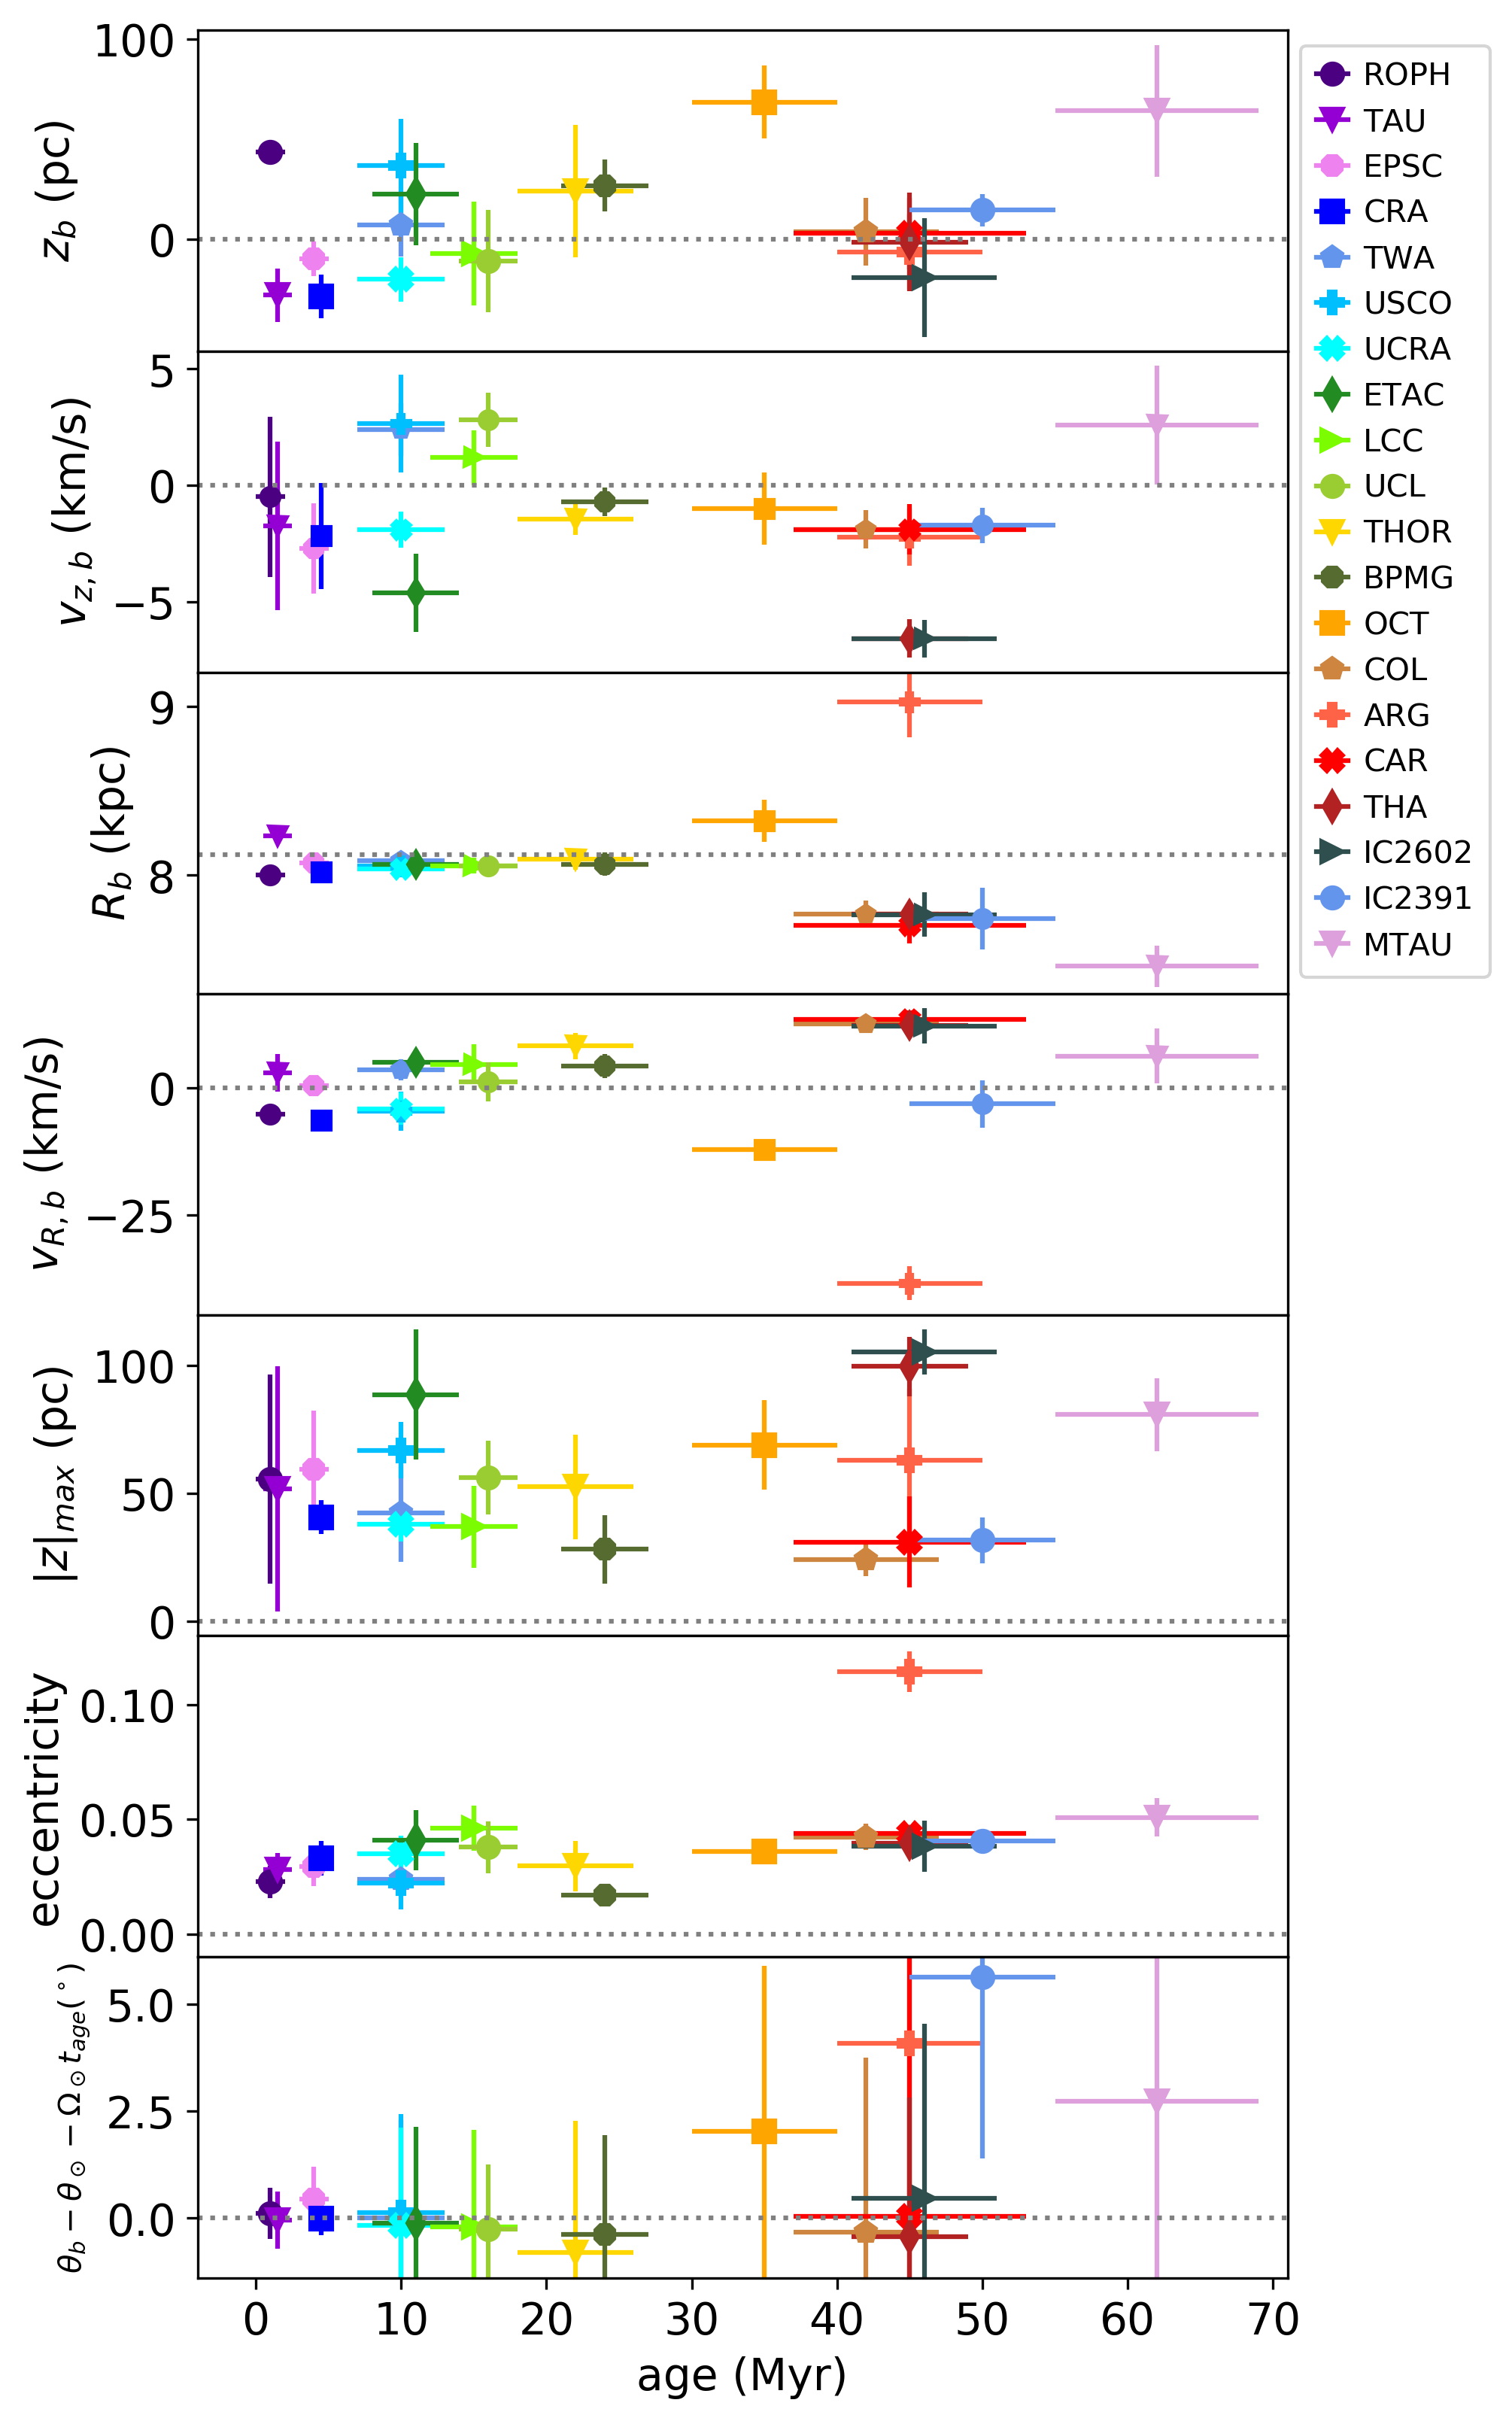

In [91]:
# this is used in paper!
def dobirthfig1_new(figname):
    nn = len(df.X)
    nplots = 7
    fig,axarr = plt.subplots(nplots,1,sharex=True,sharey=False,figsize=(7,12),dpi=300)
    plt.subplots_adjust(left=0.15, bottom=0.10, right=0.84, top=0.93, wspace=0, hspace=0)
    angfac = 180.0/np.pi
    msa = 7; zoa = 1
    markerlist=['o','v','8','s','p','P','X','d','>']
    lmk = len(markerlist)
    for isa in range(nn):
        axarr[0].errorbar(df['age'][isa],zb_arr[isa]*1e3,xerr=df['e_age'][isa],yerr=ezb_tot_arr[isa]*1e3,\
                  color=mcolorlist[isa],zorder=zoa)
        axarr[0].plot(df['age'][isa],zb_arr[isa]*1e3,marker=markerlist[isa%lmk],\
                  color=mcolorlist[isa],label=df['name'][isa],zorder=zoa,ms=msa)
        axarr[1].errorbar(df['age'][isa],vzb_arr[isa],xerr=df['e_age'][isa],yerr=evzb_tot_arr[isa],\
                  color=mcolorlist[isa],zorder=zoa,ms=msa)
        axarr[1].plot(df['age'][isa],vzb_arr[isa],marker=markerlist[isa%lmk],\
                  color=mcolorlist[isa],zorder=zoa)
        axarr[2].errorbar(df['age'][isa],Rb_arr[isa],xerr=df['e_age'][isa],yerr=eRb_tot_arr[isa],\
                  color=mcolorlist[isa],zorder=zoa,ms=msa)
        # new!
        #axarr[2].errorbar(df['age'][isa],Rb_arr[isa],yerr=dr_arr_one[isa]/1e3,\
        #          color=mcolorlist[isa],zorder=zoa,ms=1,ecolor='grey',elinewidth=1,capsize=3)
        axarr[2].plot(df['age'][isa],Rb_arr[isa],marker=markerlist[isa%lmk],\
                    color=mcolorlist[isa],zorder=zoa)
        axarr[3].errorbar(df['age'][isa],vrb_arr[isa],xerr=df['e_age'][isa],yerr=evrb_tot_arr[isa],\
                  color=mcolorlist[isa],zorder=zoa,ms=msa)
        axarr[3].plot(df['age'][isa],vrb_arr[isa],marker=markerlist[isa%lmk],\
                      color=mcolorlist[isa],zorder=zoa)
        axarr[4].errorbar(df['age'][isa],zmed_arr_one[isa],xerr=df['e_age'][isa],yerr=zsig_arr_one[isa],\
                  color=mcolorlist[isa],zorder=zoa,ms=msa)
        axarr[4].plot(df['age'][isa],zmed_arr_one[isa],marker=markerlist[isa%lmk],\
                  color=mcolorlist[isa],zorder=zoa,ms=msa)
        
        axarr[5].errorbar(df['age'][isa],e_arr_one[isa],xerr=df['e_age'][isa],yerr=esig_arr_one[isa],\
                  color=mcolorlist[isa],zorder=zoa,ms=msa)
        axarr[5].plot(df['age'][isa],e_arr_one[isa],marker=markerlist[isa%lmk],\
                  color=mcolorlist[isa],zorder=zoa,ms=msa)
        
        dth = tb_arr[isa] - df['age'][isa]/1e3*Gcon.om0
        dth *= angfac
        axarr[6].errorbar(df['age'][isa],dth,xerr=df['e_age'][isa],yerr=etb_tot_arr[isa]*angfac/2,\
                  color=mcolorlist[isa],zorder=zoa,ms=msa)
        axarr[6].plot(df['age'][isa],dth,marker=markerlist[isa%lmk],\
                  color=mcolorlist[isa],zorder=zoa,ms=msa)
        
        
      
    axarr[0].set_xlim([-4,71])
    xmin, xmax = axarr[0].get_xlim()
    axarr[2].set_ylim([7.3,9.2])
    axarr[5].set_ylim([-0.01,0.13])
    
    # horizontal grey lines
    axarr[0].plot([xmin,xmax],[0,0],':',color='gray',zorder=2)
    axarr[1].plot([xmin,xmax],[0,0],':',color='gray',zorder=2)
    axarr[2].plot([xmin,xmax],[Gcon.R0,Gcon.R0],':',color='gray',zorder=2)
    axarr[3].plot([xmin,xmax],[0,0],':',color='gray',zorder=2)
    axarr[4].plot([xmin,xmax],[0,0],':',color='gray',zorder=2)
    axarr[5].plot([xmin,xmax],[0,0],':',color='gray',zorder=2)
    
    axarr[6].plot([xmin,xmax],[0,0],':',color='gray',zorder=2)
    axarr[6].set_ylabel(r'$\theta_b - \theta_\odot - \Omega_\odot t_{age} (^\circ)$',fontsize=10)
    axarr[6].set_ylim([-1.4,6.1])

    axarr[nplots-1].set_xlabel('age (Myr)',fontsize=14)
    axarr[0].set_ylabel(r'$z_b$ (pc)',fontsize=14)

    axarr[1].set_ylabel(r'$v_{z,b}$ (km/s)',fontsize=14)
    axarr[2].set_ylabel(r'$R_b$ (kpc)',fontsize=14)
    axarr[3].set_ylabel(r'$v_{R,b}$ (km/s)',fontsize=14)
    axarr[4].set_ylabel(r'$|z|_{max}$ (pc)',fontsize=14)
    axarr[5].set_ylabel('eccentricity',fontsize=14)
    axarr[0].legend(bbox_to_anchor=(1.20,1),borderpad=0.5,handlelength=1,handletextpad=0.5,\
                   borderaxespad=0.5)
    
    
    if (len(figname)>3):
        plt.savefig(figname)
    
dobirthfig1_new('birth1.png')


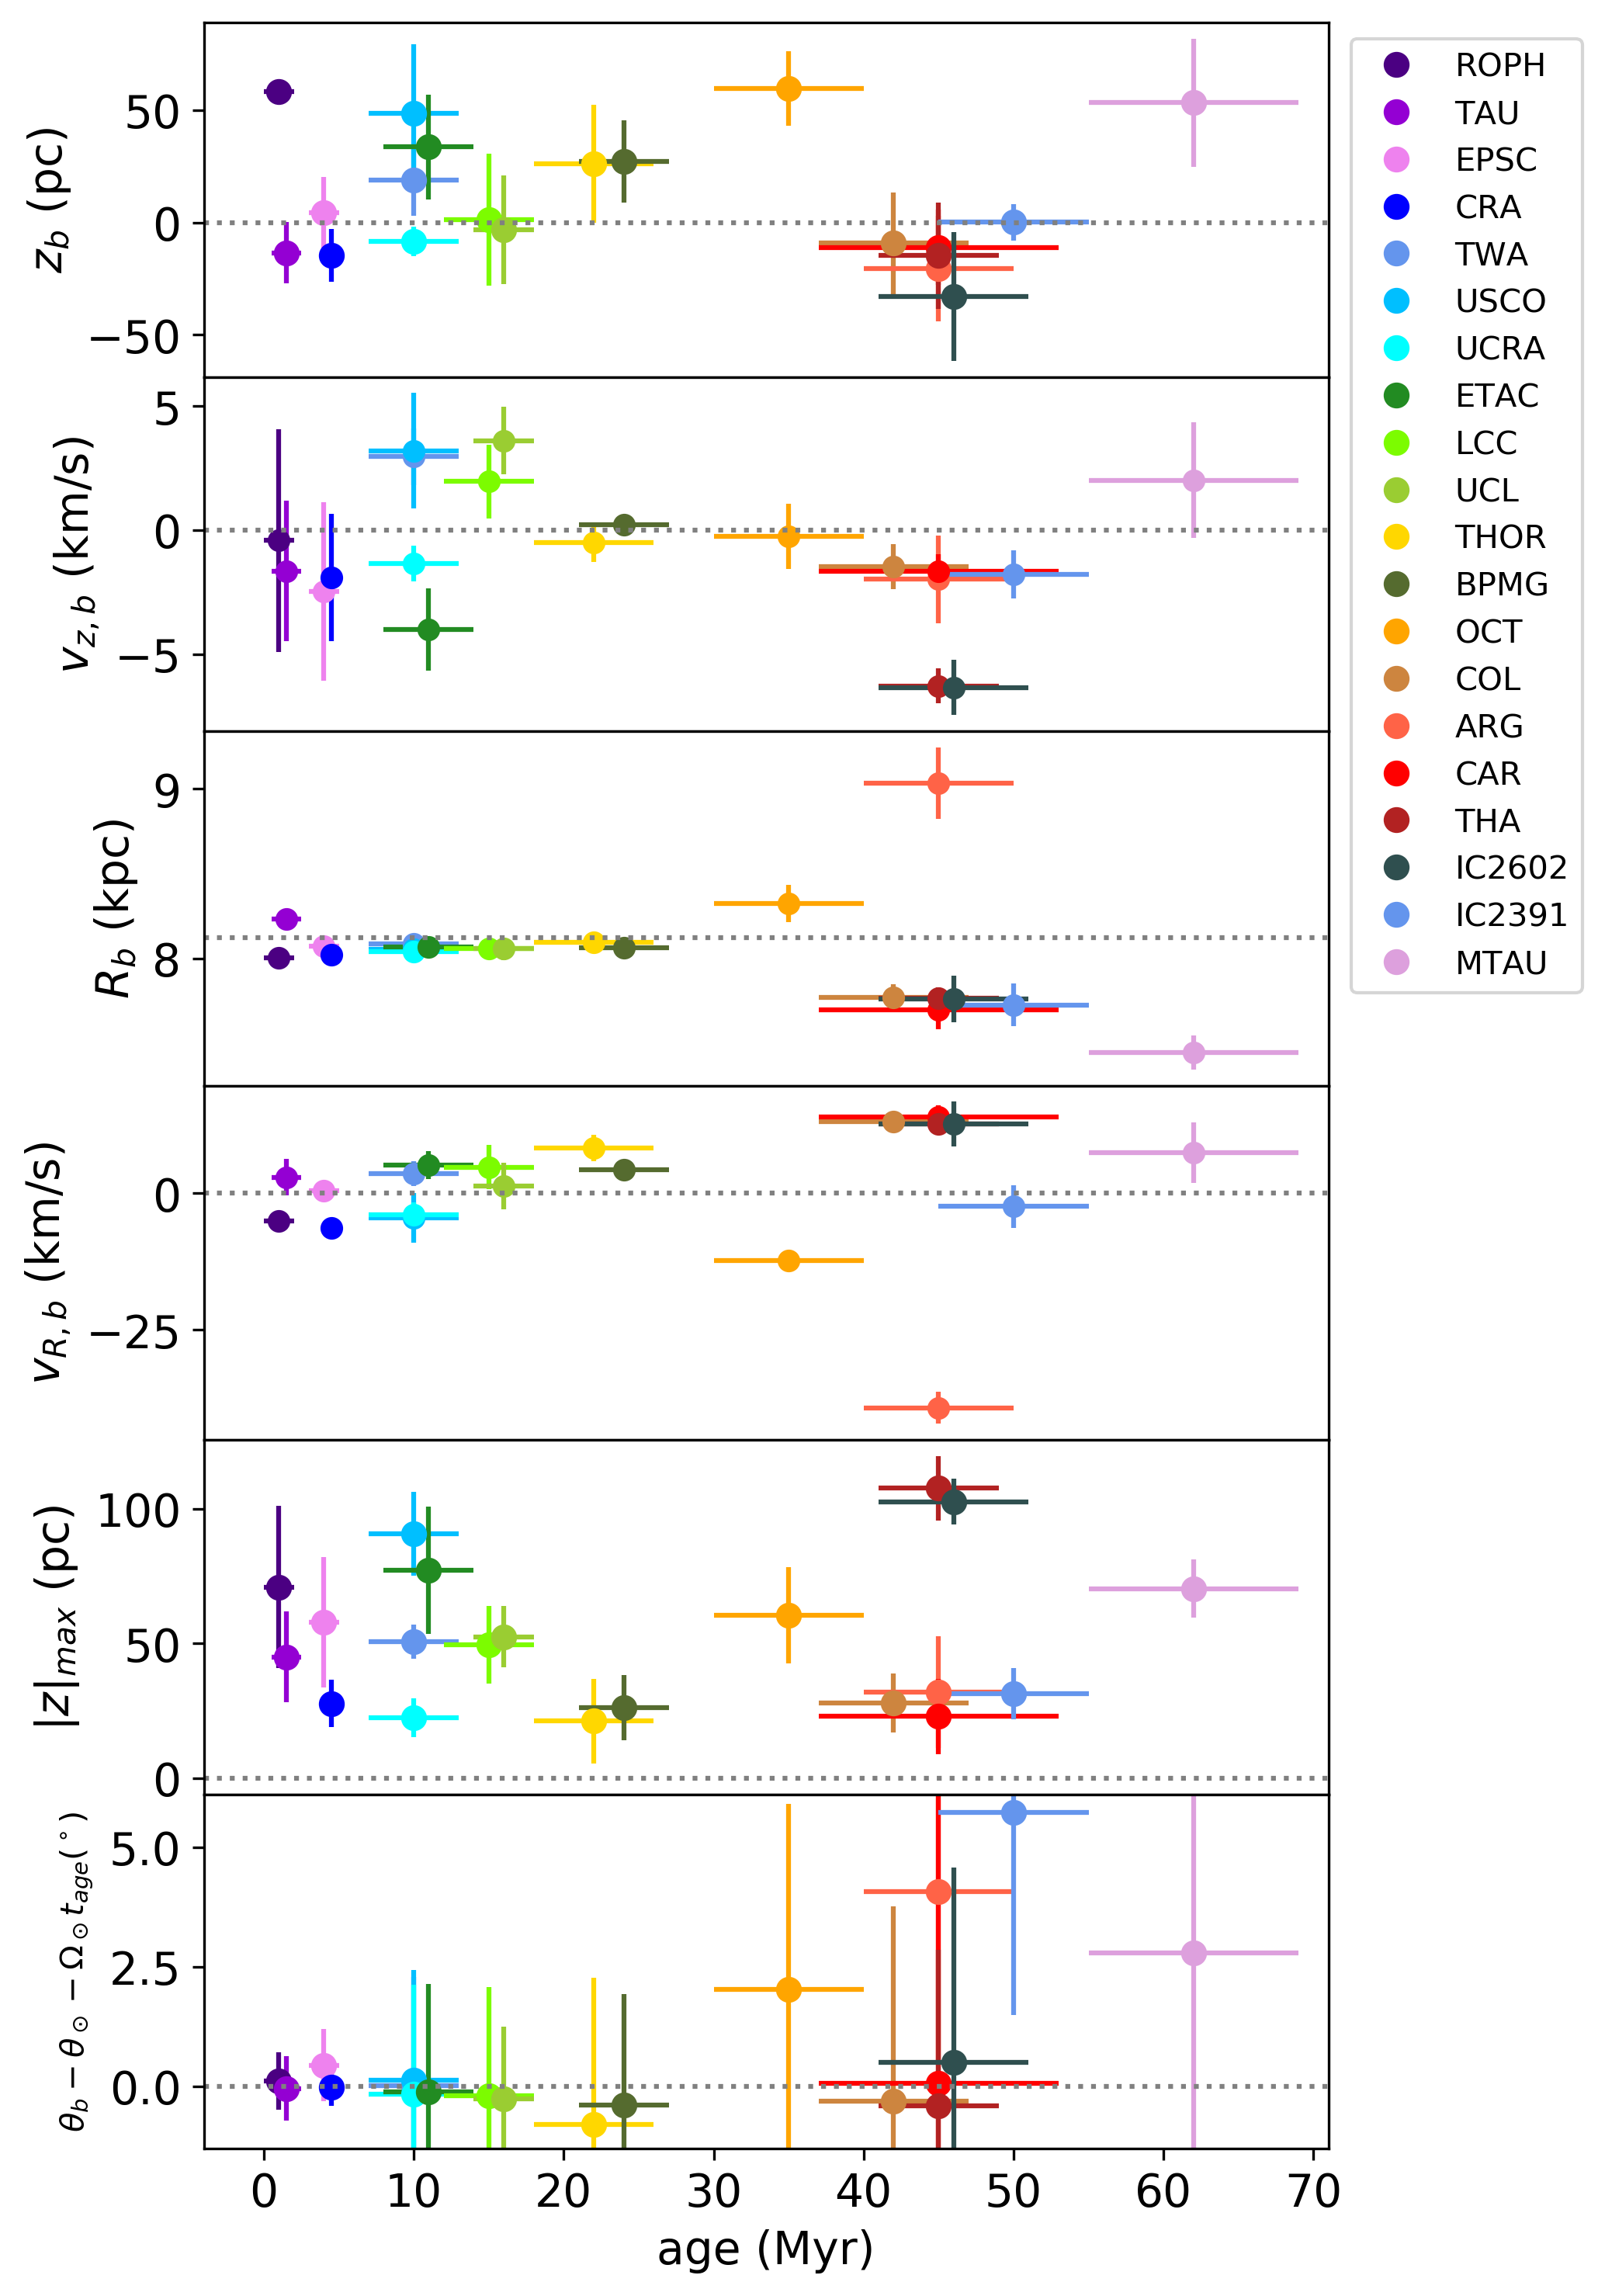

In [224]:
# check that orbits don't stronglly depend on Zsun
npoints=8; efac=0.1
efac=1.

Gconz0 =  Galconstants
Gconz0.Zsun = 20. 

zmed_arr_one,zsig_arr_one = med_zmax(df,npoints,Gconz0,efac)
zb_arr,ezb_arr,Rb_arr,eRb_arr,tb_arr,etb_arr,vzb_arr,evzb_arr,vrb_arr,evrb_arr,L_arr=\
    births(df,Gconz0)
#add errors in quadrature
ezb_tot_arr = np.sqrt(ezb_arr**2 + ezbo_arr**2)
eRb_tot_arr = np.sqrt(eRb_arr**2 + eRbo_arr**2)
evzb_tot_arr = np.sqrt(evzb_arr**2 + evzbo_arr**2)
evrb_tot_arr = np.sqrt(evrb_arr**2 + evrbo_arr**2)
etb_tot_arr = np.sqrt(etb_arr**2 + etbo_arr**2)
dobirthfig1_new('birth1_z0.png')

In [85]:
# make r z plots but only include points within [age_min,age_max)
# here df is the stellar association table,
# npoints is the number of integrations per stellar association
# Gcon is the structure containing galactic constants
# calls back-integrate_sa()
def oneplotrz(age_min,age_max,npoints,df,Gcon,figname):
    fig,axarr = plt.subplots(1,1,sharex=False,sharey=False,figsize=(11,4))
    plt.subplots_adjust(left=None, bottom=0.17, right=None, top=None, wspace=None, hspace=None)
    rgba_colors = np.zeros((301,4))  # color list including alpha
    
    todeg = 180.0/np.pi   # convert angles to degrees
    for isa in range(len(df.X)-1,-1,-1): # go from oldest to youngest
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        for j in range(npoints):   # number of integrations
            rgba_colors[:,0]=rgba[0]
            rgba_colors[:,1]=rgba[1]
            rgba_colors[:,2]=rgba[2]
            i_output = back_integrate_sa(df,isa,Gcon,1)
            rgba_colors[:,3]=i_output.aw_arr # opacity weight
            ii = (np.abs(i_output.t_arr) >= age_min/1e3) & (np.abs(i_output.t_arr) < age_max/1e3)
            #print(ii)
            if (j==0):
                axarr.scatter(0,0,color=rgba,s=5,label=df['name'][isa])

            #axarr.scatter(i_output.dtheta_arr[ii]*todeg,i_output.r_arr[ii],color=rgba_colors[ii],s=5,zorder=2)
            axarr.scatter(i_output.r_arr[ii],i_output.z_arr[ii],color=rgba_colors[ii],s=5,zorder=2)
            
    axarr.set_ylabel(r'$z_g$ (kpc)',fontsize=18);  
    axarr.set_xlabel(r'$R_g$ (kpc)',fontsize=18);
    axarr.set_ylim([-0.16,0.16])
    axarr.set_xlim([6.7,8.9])
    xmin, xmax = axarr.get_xlim()
    ymin, ymax = axarr.get_ylim()
    axarr.plot([xmin,xmax],[0,0],':',color='grey',zorder=1)
    axarr.plot([Gcon.R0,Gcon.R0],[ymin,ymax],':',color='grey',zorder=1)
            
    axarr.legend(ncol=2,markerscale=3.,borderpad=0.1,labelspacing=0.1,\
                         handlelength=0.5,handletextpad=0.5,columnspacing=0.5,fontsize=14)
    #axarr.arrow(17,8.50,-12,0,head_width=0.1,head_length=1.5,width=0.02)
    #axarr.text(11,8.57,'rotation',fontsize=14,ha='center',va='center')
            
    if (len(figname)>3):
        plt.savefig(figname,dpi=300)
        
    #return fig,axarr

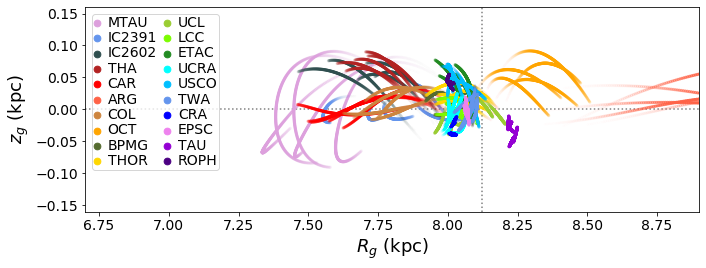

In [86]:
age_min = 0; age_max = 3000;   # age range in Myr
npoints=5
figname='rz_all.png'
oneplotrz(age_min,age_max,npoints,df,Gcon,figname)

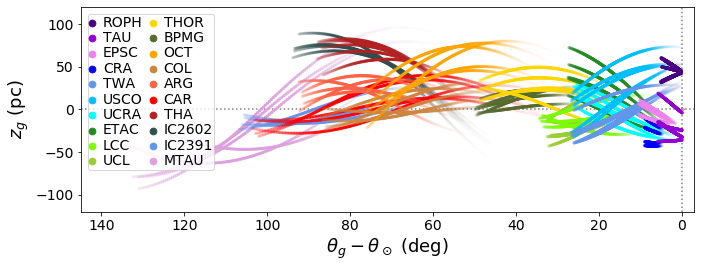

In [159]:
age_min = 0; age_max = 3000;   # age range in Myr
npoints=5
figname='thetaz_all.png'
oneplotthetaz(age_min,age_max,npoints,df,Gcon,figname)

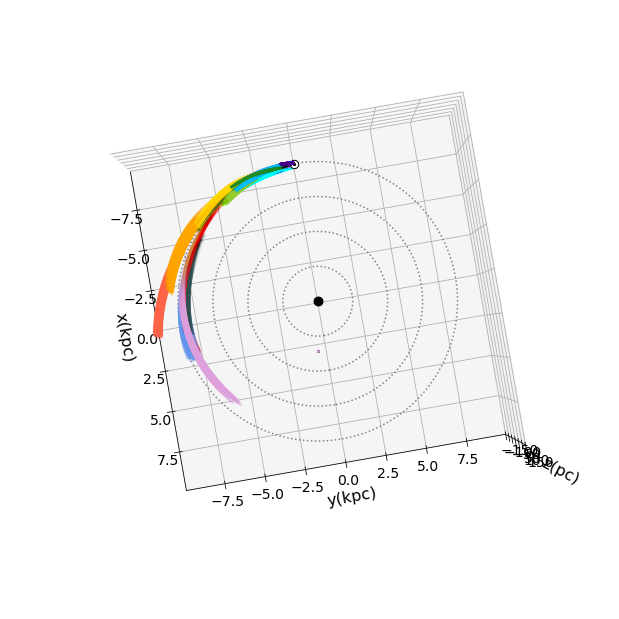

In [78]:

def mkfilename(sii,fileroot):
    istring = ''
    if (sii < 100):
        istring = istring + '0'
    if (sii < 10):
        istring = istring + '0'
    istring = istring + '{:d}'.format(sii)
    mstring = 'pngs/' + fileroot + istring + '.png'
    return mstring

# give me a circle of npoints in plane
def xyzcircle(R,npts):
    phi = np.linspace(0,2*np.pi,npts)
    #print(phi)
    x = R*np.cos(phi)
    y = R*np.sin(phi)
    z = x*0.0
    return x,y,z
#z,y,z = xyzcircle(1,180)

# make x,y,z plots in 3D but only include points within [age_min,age_max) 
# here df is the stellar association table,
# npoints is the number of integrations per stellar association
# Gcon is the structure containing galactic constants
# calls back-integrate_sa()
# note that npts_integrated is a global variable telling us how many points are in each integration output
npts_integrated=301   #number of points to store integration
def movieplot3d(age_min,age_max,npoints,df,Gcon,elev0,amp_elev,az0,nd,fileroot):
    fig = plt.figure(figsize=(10,10))
    #fig,axarr = plt.subplots(1,1,sharex=False,sharey=False,figsize=(11,4.5))
    axarr = fig.add_subplot(111, projection='3d')
    plt.subplots_adjust(left=0.11, bottom=0.11, right=0.95, top=0.95, wspace=None, hspace=None)
    rgba_colors = np.zeros((npts_integrated,4))  # color list including alpha
    
    todeg = 180.0/np.pi   # convert angles to degrees
    # loop over associations, for labels only, order of age
    for isa in range(len(df.X)):
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        axarr.scatter3D(0, 0, 10000, color=rgba,s=2,label=df['name'][isa]);
        # for labelling
    # loop over associations
    for isa in range(len(df.X)-1,-1,-1): # go from oldest association to youngest association
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        for j in range(npoints):   # number of integrations to do for each stellar association
            rgba_colors[:,0]=rgba[0]
            rgba_colors[:,1]=rgba[1]
            rgba_colors[:,2]=rgba[2]
            i_output = back_integrate_sa(df,isa,Gcon,1,npts_integrated)  # integration output information
            rgba_colors[:,3]=i_output.aw_arr  # weights based on age
            iia = (np.abs(i_output.t_arr) >= age_min/1e3) & (np.abs(i_output.t_arr) < age_max/1e3)
            #iib = (i_output.z_arr > zmin) & (i_output.z_arr < zmax)
            ii = iia   # only plot age range and z range
            #print(ii)
            #if (j==0):
                #axarr.scatter(0,0,color=rgba,s=5,label=df['name'][isa])  # for labelling

            axarr.scatter3D(i_output.x_arr[ii],i_output.y_arr[ii],i_output.z_arr[ii]*1e3,color=rgba_colors[ii],s=2,zorder=2)
            
    axarr.set_xlabel(r'x(kpc)',fontsize=16,labelpad=15);  
    axarr.set_ylabel(r'y(kpc)',fontsize=16,labelpad=15);
    axarr.set_zlabel(r'z(pc)' ,fontsize=16,labelpad=15);

    axarr.set_xlim([-9.5,9.5])
    axarr.set_ylim([-9.5,9.5])
    axarr.set_zlim([-150,150])
    #xmin, xmax = axarr.get_xlim() # this is angle in degrees
    #ymin, ymax = axarr.get_ylim()
    #zmin, zmax = axarr.get_zlim()
   
    # the legend!       
    #axarr.legend(ncol=5,markerscale=4.,borderpad=0.2,labelspacing=0.1,\
    #                     handlelength=0.5,handletextpad=0.4,columnspacing=0.3,fontsize=14,loc='upper right')
    axarr.scatter3D(0,0,0,color='black',s=80)   #Galactic center is a black dot
    axarr.scatter3D(-Gcon.R0,0,0,'o',color='black',s=70) # sun
    axarr.scatter3D(-Gcon.R0,0,0,'o',color='white',s=40) # sun
    axarr.scatter3D(-Gcon.R0,0,0,'o',color='black',s=5) # sun
    # rotation arrow
    #axarr.arrow(17,8.50,-12,0,head_width=0.1,head_length=1.5,width=0.02)
    #axarr.text(11,8.57,'rotation',fontsize=14,ha='center',va='center')
    
    axarr.view_init(elev=elev0, azim=az0) # angles for 3D camera view  in degrees
    
    # show some dotted grey circles 
    xc,yc,zc = xyzcircle(Gcon.R0,180)
    axarr.plot(xc,yc,zc,':',color='grey')
    xc,yc,zc = xyzcircle(Gcon.R0*0.75,180)
    axarr.plot(xc,yc,zc,':',color='grey')
    xc,yc,zc = xyzcircle(Gcon.R0*0.5,180)
    axarr.plot(xc,yc,zc,':',color='grey')
    xc,yc,zc = xyzcircle(Gcon.R0*0.25,180)
    axarr.plot(xc,yc,zc,':',color='grey')
                              
        
    #nd=5 is spacing in degrees for each image
    for ii in range(0,360,nd):  # azimuthal display angle in degrees
        zelev = elev0 + amp_elev*np.cos((ii+az0)*np.pi/180)
        axarr.view_init(elev=zelev, azim=(ii+az0))  # the view for the camera
        istring = ''
        sii = int(ii/nd)
        mstring = mkfilename(sii,fileroot)
        print(mstring,end='\r')
        plt.savefig(mstring,dpi=100)
        

fileroot='movie'
agemin=0; agemax=1e10
mpoints = 5; nd=10
elev0=50; az0=0; amp_elev=40
movieplot3d(age_min,age_max,npoints,df,Gcon,elev0,amp_elev,az0,nd,fileroot)

pngs/movb001.png
pngs/movb002.png
pngs/movb048.png
pngs/movb049.png


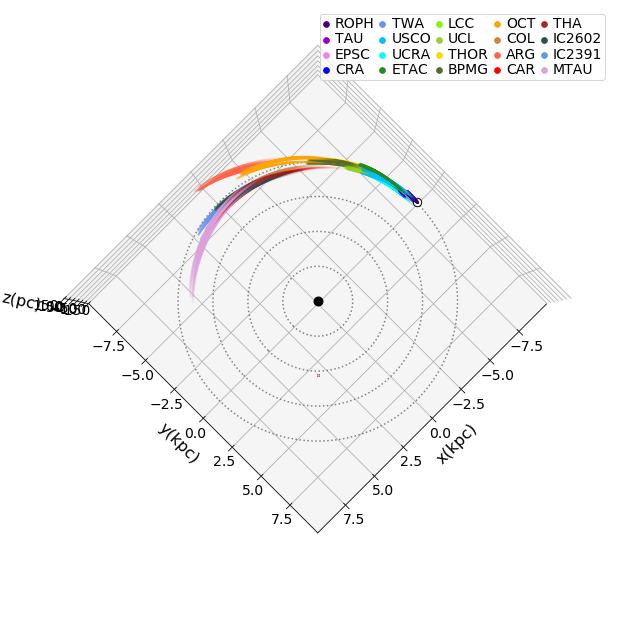

In [134]:
# make x,y,z plots in 3D but only include points within [age_min,age_max) 
# here df is the stellar association table,
# npoints is the number of integrations per stellar association
# Gcon is the structure containing galactic constants
# calls back-integrate_sa()
# note that npts_integrated is a global variable telling us how many points are in each integration output
npts_integrated=301   #number of points to store integration
def movieplot3db(age_min,age_max,npoints,df,Gcon,elev0,amp_elev,az0,nd,fileroot):
    fig = plt.figure(figsize=(10,10))
    #fig,axarr = plt.subplots(1,1,sharex=False,sharey=False,figsize=(11,4.5))
    axarr = fig.add_subplot(111, projection='3d')
    plt.subplots_adjust(left=0.11, bottom=0.11, right=0.95, top=0.95, wspace=None, hspace=None)
    rgba_colors = np.zeros((npts_integrated,4))  # color list including alpha
    
    todeg = 180.0/np.pi   # convert angles to degrees
    # loop over associations, for labels only, order of age
    for isa in range(len(df.X)):
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        axarr.scatter3D(0, 0, 10000, color=rgba,s=2,label=df['name'][isa]);
        # for labelling
    # loop over associations
    for isa in range(len(df.X)-1,-1,-1): # go from oldest association to youngest association
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        for j in range(npoints):   # number of integrations to do for each stellar association
            rgba_colors[:,0]=rgba[0]
            rgba_colors[:,1]=rgba[1]
            rgba_colors[:,2]=rgba[2]
            i_output = back_integrate_sa(df,isa,Gcon,1,npts_integrated)  # integration output information
            rgba_colors[:,3]=i_output.aw_arr  # weights based on age
            iia = (np.abs(i_output.t_arr) >= age_min/1e3) & (np.abs(i_output.t_arr) < age_max/1e3)
            #iib = (i_output.z_arr > zmin) & (i_output.z_arr < zmax)
            ii = iia   # only plot age range and z range
            #print(ii)
            #if (j==0):
                #axarr.scatter(0,0,color=rgba,s=5,label=df['name'][isa])  # for labelling

            axarr.scatter3D(i_output.x_arr[ii],i_output.y_arr[ii],i_output.z_arr[ii]*1e3,color=rgba_colors[ii],s=2,zorder=2)
            
    axarr.set_xlabel(r'x(kpc)',fontsize=16,labelpad=15);  
    axarr.set_ylabel(r'y(kpc)',fontsize=16,labelpad=15);
    axarr.set_zlabel(r'z(pc)' ,fontsize=16,labelpad=15);

    axarr.set_xlim([-9.5,9.5])
    axarr.set_ylim([-9.5,9.5])
    axarr.set_zlim([-150,150])
    #xmin, xmax = axarr.get_xlim() # this is angle in degrees
    #ymin, ymax = axarr.get_ylim()
    #zmin, zmax = axarr.get_zlim()
   
    # the legend!       
    axarr.legend(ncol=5,markerscale=4.,borderpad=0.2,labelspacing=0.1,\
                         handlelength=0.5,handletextpad=0.4,columnspacing=0.3,fontsize=14,loc='upper right')
    axarr.scatter3D(0,0,0,color='black',s=80)   #Galactic center is a black dot
    axarr.scatter3D(-Gcon.R0,0,0,'o',color='black',s=70) # sun
    axarr.scatter3D(-Gcon.R0,0,0,'o',color='white',s=40) # sun
    axarr.scatter3D(-Gcon.R0,0,0,'o',color='black',s=5) # sun
    # rotation arrow
    #axarr.arrow(17,8.50,-12,0,head_width=0.1,head_length=1.5,width=0.02)
    #axarr.text(11,8.57,'rotation',fontsize=14,ha='center',va='center')
    
    axarr.view_init(elev=elev0, azim=az0) # angles for 3D camera view  in degrees
    
    # show some dotted grey circles 
    xc,yc,zc = xyzcircle(Gcon.R0,180)
    axarr.plot(xc,yc,zc,':',color='grey')
    xc,yc,zc = xyzcircle(Gcon.R0*0.75,180)
    axarr.plot(xc,yc,zc,':',color='grey')
    xc,yc,zc = xyzcircle(Gcon.R0*0.5,180)
    axarr.plot(xc,yc,zc,':',color='grey')
    xc,yc,zc = xyzcircle(Gcon.R0*0.25,180)
    axarr.plot(xc,yc,zc,':',color='grey')
    
    
                              
    #nd=5 is spacing in degrees for each image
    image_index = 0
    for ii in range(0,90+nd,nd):  # azimuthal display angle in degrees
        zelev = ii #elev0 + amp_elev*np.cos((ii+az0)*np.pi/180)
        axarr.view_init(elev=zelev*0.99, azim=(az0))  # the view for the camera
        istring = ''
        #sii = int(ii/nd)
        ofile = mkfilename(image_index,fileroot)
        print(ofile,end='\r')
        elev_string = 'el={:.0f}'.format(zelev)
        txt=axarr.text2D(0.05, 0.95, elev_string, transform=axarr.transAxes,fontsize=18)
        plt.savefig(ofile,dpi=100)
        txt.remove()
        if (image_index==0):
            image_index+=1
            ofile1 = mkfilename(image_index,fileroot)
            shutil.copyfile(ofile, ofile1); print(ofile1)
            image_index+=1
            ofile1 = mkfilename(image_index,fileroot)
            shutil.copyfile(ofile, ofile1); print(ofile1)
        image_index+=1   
    ofile1 = mkfilename(image_index,fileroot)
    shutil.copyfile(ofile, ofile1); print(ofile1)
    image_index+=1 
    ofile1 = mkfilename(image_index,fileroot)
    shutil.copyfile(ofile, ofile1); print(ofile1)
            
    return image_index    

fileroot='movb'
agemin=0; agemax=1e10
mpoints = 5; nd=2
elev0=50; az0=45; amp_elev=40
image_index=movieplot3db(age_min,age_max,npoints,df,Gcon,elev0,amp_elev,az0,nd,fileroot)

In [135]:
image_index

49

In [139]:
import shutil

# copy files so goes backwards
siimax = image_index +1
for sii in range(0,siimax):  # azimuthal display angle in degrees
        ofile = mkfilename(sii,fileroot)
        ofile1 = mkfilename(2*siimax-sii-1,fileroot)
        print(ofile,ofile1) #,end='\r')
        shutil.copyfile(ofile, ofile1)

pngs/movb000.png pngs/movb099.png
pngs/movb001.png pngs/movb098.png
pngs/movb002.png pngs/movb097.png
pngs/movb003.png pngs/movb096.png
pngs/movb004.png pngs/movb095.png
pngs/movb005.png pngs/movb094.png
pngs/movb006.png pngs/movb093.png
pngs/movb007.png pngs/movb092.png
pngs/movb008.png pngs/movb091.png
pngs/movb009.png pngs/movb090.png
pngs/movb010.png pngs/movb089.png
pngs/movb011.png pngs/movb088.png
pngs/movb012.png pngs/movb087.png
pngs/movb013.png pngs/movb086.png
pngs/movb014.png pngs/movb085.png
pngs/movb015.png pngs/movb084.png
pngs/movb016.png pngs/movb083.png
pngs/movb017.png pngs/movb082.png
pngs/movb018.png pngs/movb081.png
pngs/movb019.png pngs/movb080.png
pngs/movb020.png pngs/movb079.png
pngs/movb021.png pngs/movb078.png
pngs/movb022.png pngs/movb077.png
pngs/movb023.png pngs/movb076.png
pngs/movb024.png pngs/movb075.png
pngs/movb025.png pngs/movb074.png
pngs/movb026.png pngs/movb073.png
pngs/movb027.png pngs/movb072.png
pngs/movb028.png pngs/movb071.png
pngs/movb029.p

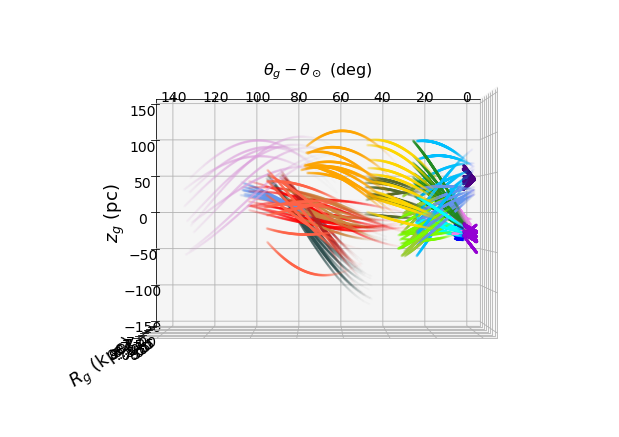

In [99]:
# make r z plotsonly include points within [age_min,age_max)
# plot panels in 3 d make another movie, idea to replace figures thetaz_all_r4.png and rtheta_allz4.png
# here df is the stellar association table,
# npoints is the number of integrations per stellar association
# Gcon is the structure containing galactic constants
# calls back-integrate_sa()
def rthetaz3d(age_min,age_max,npoints,df,Gcon,nd,fileroot):

    fig = plt.figure(figsize=(10,7))
    axarr = fig.add_subplot(111, projection='3d')
    plt.subplots_adjust(left=0.11, bottom=0.11, right=0.95, top=0.95, wspace=None, hspace=None)
    
    rgba_colors = np.zeros((npts_integrated,4))  # color list including alpha
    
    todeg = 180.0/np.pi   # convert angles to degrees
    axarr.set_xlabel(r'$\theta_g - \theta_\odot$ (deg)',fontsize=16,labelpad=15); 
    axarr.set_zlabel(r'$R_g$ (kpc)',fontsize=18,labelpad=15)
    axarr.set_ylabel(r'$z_g$ (pc)',fontsize=18,labelpad=15)
    zmaxr = 150
    axarr.set_zlim([7,9])
    axarr.set_xlim([145,-3])
    axarr.set_ylim([-zmaxr,zmaxr])
    #xmin, xmax = axarr[0].get_xlim()
    #ymin, ymax = axarr[0].get_ylim()
    
    
    for isa in range(len(df.X)): 
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        axarr.scatter3D(0,0,1e5,color=rgba,s=3,label=df['name'][isa])  #labels
        
    for isa in range(len(df.X)-1,-1,-1): # go from oldest to youngest
        rgba = matplotlib.colors.to_rgba(mcolorlist[isa], alpha=1)
        for j in range(npoints):   # number of integrations
            rgba_colors[:,0]=rgba[0]
            rgba_colors[:,1]=rgba[1]
            rgba_colors[:,2]=rgba[2]
            i_output = back_integrate_sa(df,isa,Gcon,1,npts_integrated) # do integration
            rgba_colors[:,3]=i_output.aw_arr
            iia = (np.abs(i_output.t_arr) >= age_min/1e3) & (np.abs(i_output.t_arr) < age_max/1e3)
            ii = iia 
            axarr.scatter(i_output.dtheta_arr[ii]*todeg,i_output.z_arr[ii]*1e3,i_output.r_arr[ii],color=rgba_colors[ii],\
                                 s=3,zorder=2)
    
    #if (leg==1):
    #    axarr[0].legend(ncol=1,markerscale=3,fontsize=14,bbox_to_anchor=(1.17,1),loc="upper right",\
    #                    handlelength=0.1,handletextpad=0.5,borderpad=0.3,labelspacing=0.1)
    
    # top axis
    #ax2 = axarr.twiny()  # share y axis
    #t1 = xmin/todeg / Gcon.om0 *1e3  # should be time in Myr
    #t2 = xmax/todeg / Gcon.om0 *1e3  
    #ax2.set_xlim(t1,t2)
    #ax2.set_xlabel(r'$t =(\theta_g - \theta_\odot)/\Omega_\odot$ (Myr)',fontsize=16);
    
    
    #nd=5 is spacing in degrees for each image
    #nd=15
    for ii in range(0,90+nd,nd):  # azimuthal display angle in degrees
        zelev = ii
        if (zelev >= 90):
            zelev=89
        axarr.view_init(elev=zelev, azim=-90)  # the view for the camera
        istring = ''
        sii = int(ii/nd)
        if (sii < 100):
            istring = istring + '0'
        if (sii < 10):
            istring = istring + '0'
        istring = istring + '{:d}'.format(sii)
        mstring = 'pngs/' + fileroot + istring + '.png'
        print(mstring,end='\r')
        plt.savefig(mstring,dpi=100)
    
 
    
age_min = 0; age_max = 3000;   # age range in Myr
npoints=10
fileroot ='rtz'
nd=5
rthetaz3d(age_min,age_max,npoints,df,Gcon,nd,fileroot)
